In [538]:
## import
from tqdm import tqdm
import numpy as np
import glob
import os
import pickle
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats 
import seaborn as sns
import mne
from mne.io import read_raw_bdf
from mne.preprocessing.ica import corrmap
import autoreject

### Behavioral analysis (RTs & errors)

In [601]:
data_path = 'E:/Projects/2020_reading/Flankers/Results/'

In [602]:
behav_files=glob.glob(data_path+'/*.csv') # returns logfiles
print(behav_files)

['E:/Projects/2020_reading/Flankers/Results\\subject-0.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-1.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-10.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-11.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-12.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-13.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-14.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-15.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-16.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-17.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-18.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-19.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-2.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-20.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-21.csv', 'E:/Projects/2020_reading/Flankers/Results\\subject-22.csv', 'E:/Projects/2020_reading/

In [603]:
df=pd.read_csv(behav_files[0], sep=',', header=0)
df=df[['avg_rt','correct', 'flanker_type', 'lexicality','response_time', 'target']] # remove the strange NAN columns etc
#df.head(10)

correct_indices = np.where(df['correct']==1)
#print(correct_indices)

In [604]:
# Create a loop to generate a dataframe with all participants' performance
all_subj = []
excluded = [5, 7,11 ]
for n_subj in range(len(behav_files)):
    if n_subj in excluded: 
        continue
    df=pd.read_csv(behav_files[n_subj], sep=',', header=0)
    subj_idx = 'subj_' + str(n_subj)
    #print(subj_idx)
    df=df[['avg_rt','correct', 'flanker_type', 'lexicality','response_time', 'target']] # remove the strange NAN columns etc
    df['subj_idx'] = subj_idx
    
    all_subj.append(df)
data = pd.concat(all_subj)

#data['response_time']= data['response_time']+150
#remove outliers and incorrect responses
outlier_max = np.mean(data['response_time']) + (2.5*np.std(data['response_time']))
outlier_min = np.mean(data['response_time']) - (2.5*np.std(data['response_time']))
data = data[data['response_time']< outlier_max]
data = data[data['response_time']>outlier_min]
data_word = data[data['lexicality']=="word"]

err_data_word = data_word.groupby(['subj_idx', 'flanker_type'], as_index=False)['correct'].mean()
err_data_word['correct']=1-err_data_word['correct']
#print(err_data_word.head(-10))
err_data = data.groupby(['subj_idx', 'flanker_type'], as_index=False)['correct'].mean()
err_data['correct']=1-err_data['correct']
#print(err_data.head(-10))

rt_data_word = data_word[data_word['correct']==1]
rt_data_word = rt_data_word.groupby(['subj_idx', 'flanker_type'],as_index=False)['response_time'].mean()
#print(rt_data_word.head(-10))
rt_data_word['response_time'] = rt_data_word['response_time']+150

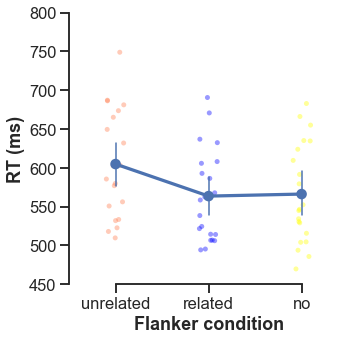

In [605]:
# Initialize the figure
f, ax = plt.subplots(figsize=(5,5))

# Show each observation with a scatterplot
sns.stripplot(x="flanker_type", y="response_time",
              data=rt_data_word, dodge=False, jitter=True,
              palette=["coral", "blue", "yellow"],
              alpha=.4, zorder=1,order=["unrelated", "related","no"])

# Show the conditional means
sns.pointplot(x="flanker_type", y="response_time", 
              data=rt_data_word, dodge=.05, join=True,errwidth=1.5,
              
                scale=0.8,order=["unrelated", "related","no"],bw=.2)
ax.set_yticks([450, 500, 550, 600,650, 700, 750, 800])
ax.set_xlabel("Flanker condition",fontdict=dict(weight='bold'))
ax.set_ylabel("RT (ms)",fontdict=dict(weight='bold'))

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

In [606]:
data.to_csv('E:/Projects/2020_reading/Flankers/all_behav.csv') 
data[data['subj_idx']=="subj_0"].head(10)


avg_rt  correct flanker_type lexicality  response_time          target  \
0     551        1           no       word            345           lent    
1     544        1    unrelated       word            449  ment drap ment   
2     536        1    unrelated    nonword            431  sabe cofi sabe   
3     532        1      related    nonword            462  uise uise uise   
4     525        1      related       word            421  dire dire dire   
5     517        1    unrelated    nonword            378  flin uter flin   
6     507        1      related       word            326  deux deux deux   
7     498        1           no       word            333           oeuf    
8     496        1      related       word            464  amer amer amer   
9     492        1    unrelated    nonword            400  momb rers momb   

  subj_idx  
0   subj_0  
1   subj_0  
2   subj_0  
3   subj_0  
4   subj_0  
5   subj_0  
6   subj_0  
7   subj_0  
8   subj_0  
9   subj_0

In [607]:
data2savestim = data.drop_duplicates(subset="target").copy(deep=True)

data2savestim.to_csv('E:/Projects/2020_reading/Flankers/stim.csv')

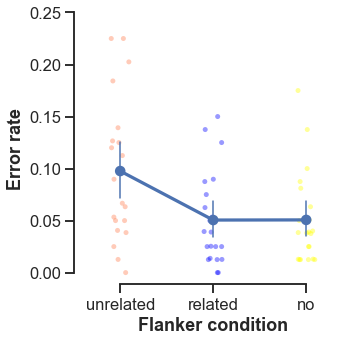

In [610]:
# Initialize the figure
f, ax = plt.subplots(figsize=(5,5))

# Show each observation with a scatterplot
sns.stripplot(x="flanker_type", y="correct",
              data=err_data_word, dodge=False, jitter=True,
                palette=["coral", "blue", "yellow"],

              alpha=.4, zorder=1,order=["unrelated", "related","no"])
# Show the conditional means
sns.pointplot(x="flanker_type", y="correct", 
              data=err_data_word, dodge=.05, join=True,errwidth=1.5,
                scale=0.8,order=["unrelated", "related","no"],bw=.2)
ax.set_yticks([0, 0.05, 0.10, 0.15,0.20, 0.25])
ax.set_xlabel("Flanker condition",fontdict=dict(weight='bold'))
ax.set_ylabel("Error rate",fontdict=dict(weight='bold'))

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)


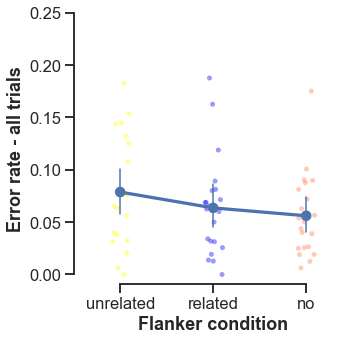

In [547]:
# Initialize the figure
f, ax = plt.subplots(figsize=(5,5))

# Show each observation with a scatterplot
sns.stripplot(x="flanker_type", y="correct",
              data=err_data, dodge=False, jitter=True,
              palette=["yellow", "blue", "coral"],
              alpha=.4, zorder=1,order=["unrelated", "related","no"])

# Show the conditional means
sns.pointplot(x="flanker_type", y="correct", 
              data=err_data, dodge=.05, join=True,errwidth=1.5,
                scale=0.8,order=["unrelated", "related","no"],bw=.2)
ax.set_yticks([0, 0.05, 0.10, 0.15,0.20, 0.25])
ax.set_xlabel("Flanker condition",fontdict=dict(weight='bold'))
ax.set_ylabel("Error rate - all trials",fontdict=dict(weight='bold'))

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)


### EEG preprocessing

In [6]:
data_path = "E:/Projects/2020_reading/Flankers/EEG Results/"
EEG_files = glob.glob(data_path+'*.bdf') # returns 40 EEG files
print('there are %i EEG files' %len(EEG_files))

there are 24 EEG files


In [11]:
montage = mne.channels.make_standard_montage(kind='standard_1005')
print(montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 343 channels>


  0%|                                                   | 0/24 [00:00<?, ?it/s]

Currently on ppn  0
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_0.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4239359  =      0.000 ...  2070.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

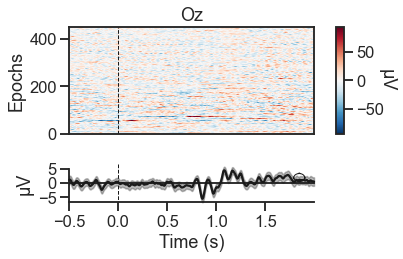

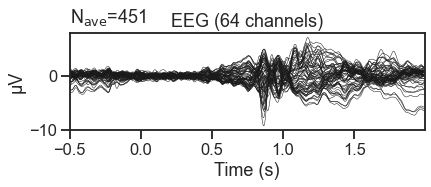

Overwriting existing file.


  4%|█▊                                         | 1/24 [01:02<24:06, 62.89s/it]

Currently on ppn  1
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4397055  =      0.000 ...  2147.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 27.9s.
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'Fp2', 'F6']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'Fpz', 'Fp2', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'FT7', 'Fpz', 'Fp2', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : [

    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['C5', 'T7']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
162 bad epochs dropped
318 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


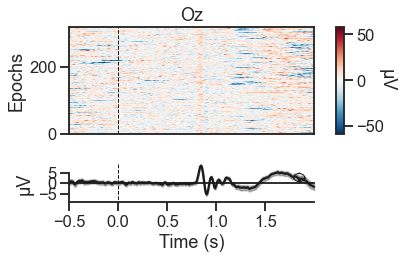

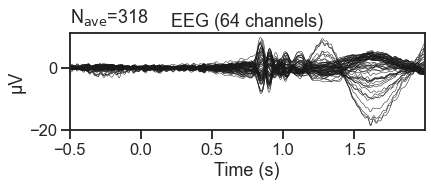

Overwriting existing file.


  8%|███▌                                       | 2/24 [02:10<23:36, 64.39s/it]

Currently on ppn  2
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4202495  =      0.000 ...  2052.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 36.1s.
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['P5']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['P5']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
  

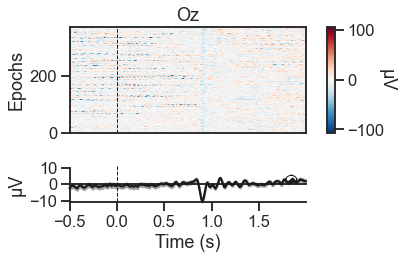

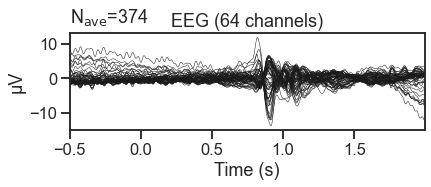

Overwriting existing file.


 12%|█████▍                                     | 3/24 [03:22<23:20, 66.68s/it]

Currently on ppn  3
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_3.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4218879  =      0.000 ...  2060.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 27.5s.
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F8', 'FT8', 'FCz', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C1', 'C5', 'TP7', 'CP5', 'P1', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F8', 'FT8', 'FCz', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F8', 'FT8', 'FCz', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  e

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'FCz', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['AF3', 'FC1', 'TP8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'FCz', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'FCz', 'C6', 'T8', 'TP8',

    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'FCz', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FC6', 'FCz', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P3', 'P7'

    Rejecting  epoch based on EEG : ['PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FCz', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FCz', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'FCz', 'C6', 'T8', 'TP8',

    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Pz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF3', 'F3']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['AF7', 'F5']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Oz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F6', 'F8', 'FT8

    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC3', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['FC1', 'C5', 'TP7', 'CP5', 'P1', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'FC5', 'FC3', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P7', 'P9', 'PO7', 'O1', 'Iz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F2', 'F6', 'F8', 'FT8', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['CP4']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F5', 'FC5', 'FC3', 'FC1', 'C5', 'TP7', 'CP5', 'P1', 'P7', 'P9', 'PO7', 

251 bad epochs dropped
229 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


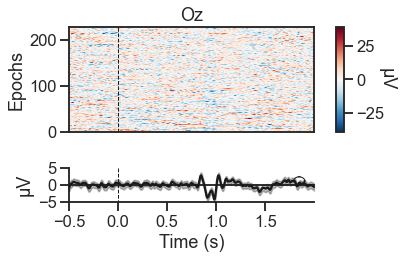

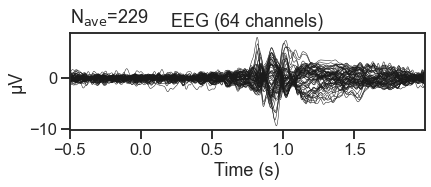

Overwriting existing file.


 17%|███████▏                                   | 4/24 [04:30<22:21, 67.06s/it]

Currently on ppn  4
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_4.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4261887  =      0.000 ...  2081.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 24.3s.
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'P5', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fp

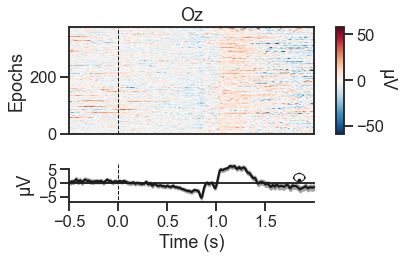

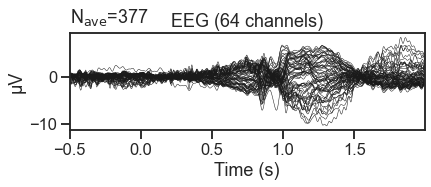

Overwriting existing file.


 21%|████████▉                                  | 5/24 [05:33<20:46, 65.62s/it]

Currently on ppn  5
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_5.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4304895  =      0.000 ...  2102.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 18.9s.
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'P2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Fp1', 'P7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['C5', 'P7']
    Rejecting  epoch based on EEG : ['Fp1', 'P7', 'Fpz']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG 

    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecti

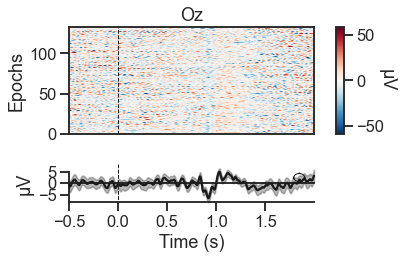

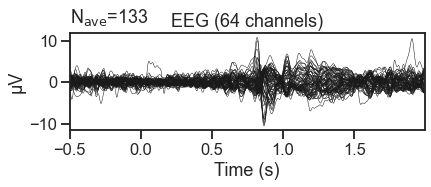

Overwriting existing file.


 25%|██████████▊                                | 6/24 [06:29<18:51, 62.83s/it]

Currently on ppn  6
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_6.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4288511  =      0.000 ...  2094.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 27.0s.
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['Fp1', 'POz', 'Fpz']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7', 'FT7', 'P9', 'F8', 'FC6', 'P10']
    Rejecting  epoch based on EEG : ['Fp1']
    R

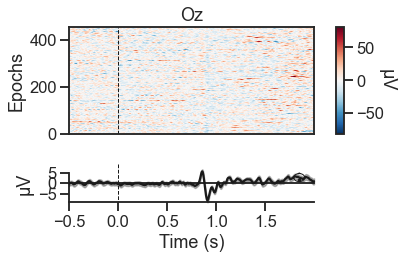

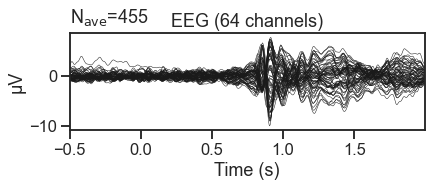

Overwriting existing file.


 29%|████████████▌                              | 7/24 [07:30<17:41, 62.42s/it]

Currently on ppn  7
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_7.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4331519  =      0.000 ...  2115.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 27.9s.
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'F7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : 

    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejec

    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz

    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'TP7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fp

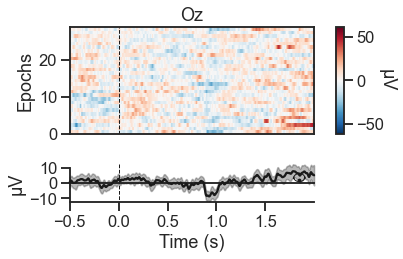

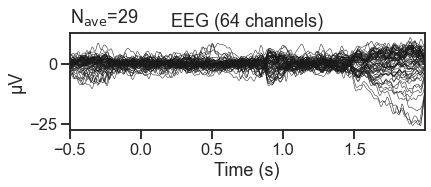

Overwriting existing file.


 33%|██████████████▎                            | 8/24 [08:32<16:34, 62.16s/it]

Currently on ppn  8
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_8.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4255743  =      0.000 ...  2078.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 19.9s.
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['F7'

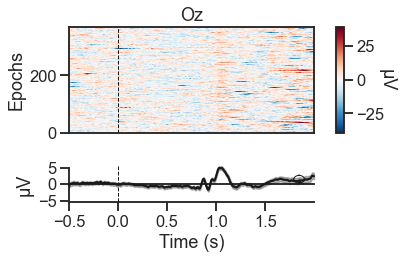

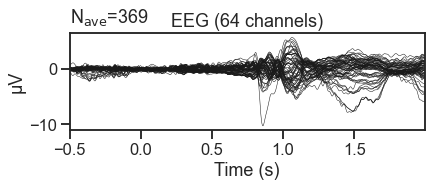

Overwriting existing file.


 38%|████████████████▏                          | 9/24 [09:30<15:13, 60.87s/it]

Currently on ppn  9
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_9.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4128767  =      0.000 ...  2016.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 20.3s.
0 bad epochs dropped
480 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


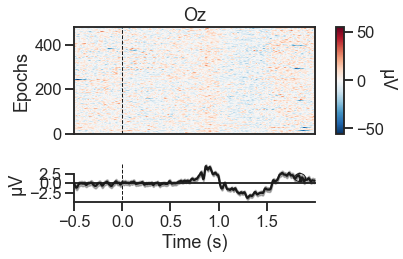

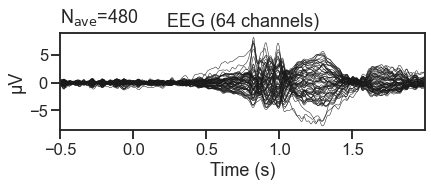

Overwriting existing file.


 42%|█████████████████▌                        | 10/24 [10:28<14:01, 60.11s/it]

Currently on ppn  10
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_10.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4222975  =      0.000 ...  2062.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 21.2s.
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['CPz']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['TP8']
    Rejecting  epoch based on EEG : ['TP8']
    

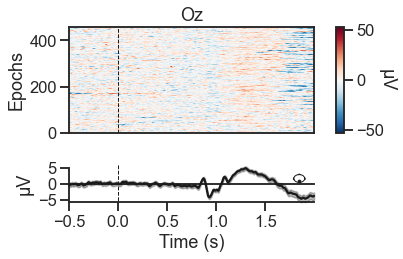

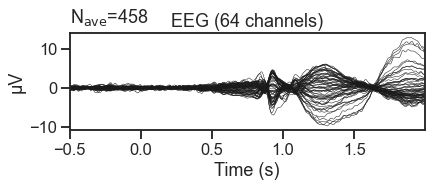

Overwriting existing file.


 46%|███████████████████▎                      | 11/24 [11:29<13:05, 60.45s/it]

Currently on ppn  11
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_11.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4323327  =      0.000 ...  2111.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 73.7s.
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1']
  

    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : [

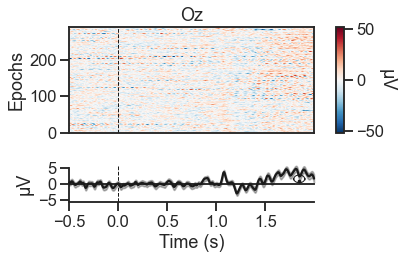

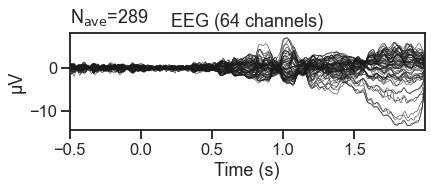

Overwriting existing file.


 50%|█████████████████████                     | 12/24 [13:21<15:10, 75.89s/it]

Currently on ppn  12
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_12.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4155391  =      0.000 ...  2029.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 37.5s.
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
191 bad epochs dropped
289 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


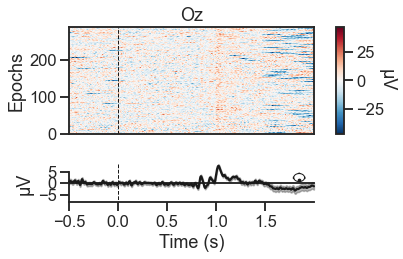

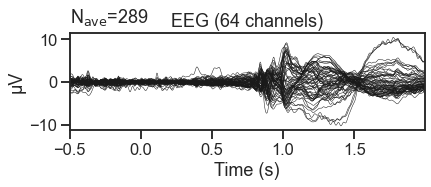

Overwriting existing file.


 54%|██████████████████████▊                   | 13/24 [14:32<13:36, 74.24s/it]

Currently on ppn  13
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_13.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4118527  =      0.000 ...  2011.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 19.9s.
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8

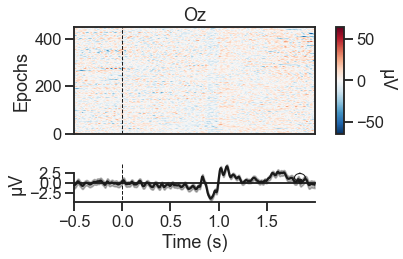

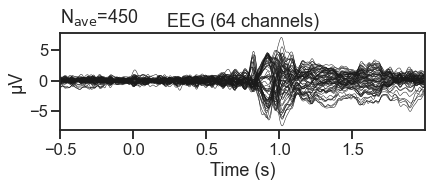

Overwriting existing file.


 58%|████████████████████████▌                 | 14/24 [15:27<11:26, 68.65s/it]

Currently on ppn  14
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_14.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4276223  =      0.000 ...  2088.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 20.0s.
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch base

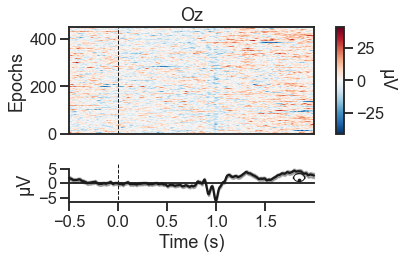

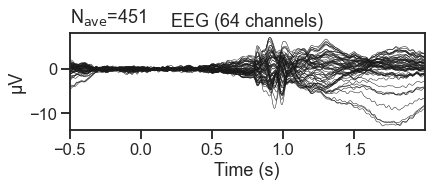

Overwriting existing file.


 62%|██████████████████████████▎               | 15/24 [16:23<09:44, 64.94s/it]

Currently on ppn  15
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_15.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4249599  =      0.000 ...  2075.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 24.4s.
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'F

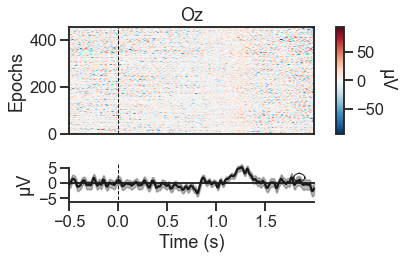

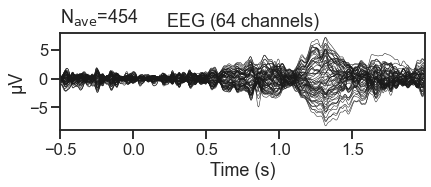

Overwriting existing file.


 67%|████████████████████████████              | 16/24 [17:22<08:24, 63.01s/it]

Currently on ppn  16
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_16.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4188159  =      0.000 ...  2045.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 20.7s.
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['AF7', 'C5']
    Rejecting  epoch based on EEG : ['Fp1', 'C5', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'P10']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch b

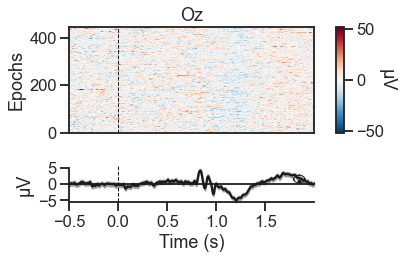

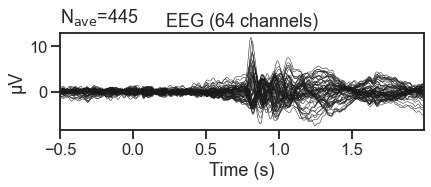

Overwriting existing file.


 71%|█████████████████████████████▊            | 17/24 [18:16<07:02, 60.36s/it]

Currently on ppn  17
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_17.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4239359  =      0.000 ...  2070.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 32.4s.
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  e

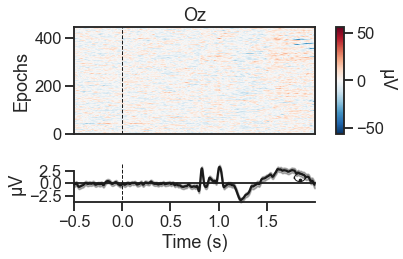

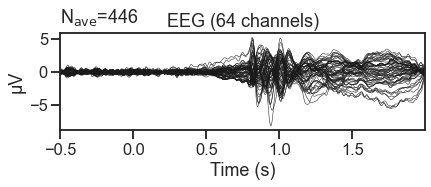

Overwriting existing file.


 75%|███████████████████████████████▌          | 18/24 [19:22<06:11, 61.89s/it]

Currently on ppn  18
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_18.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4218879  =      0.000 ...  2060.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 23.4s.
0 bad epochs dropped
480 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


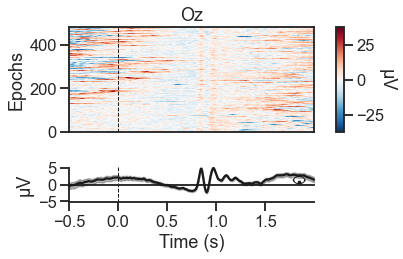

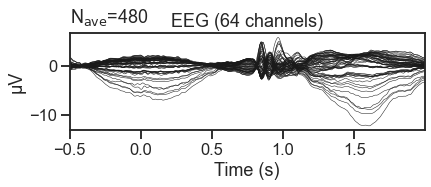

Overwriting existing file.


 79%|█████████████████████████████████▎        | 19/24 [20:19<05:03, 60.60s/it]

Currently on ppn  19
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_19.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4141055  =      0.000 ...  2022.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 28.4s.
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF7', 'F8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
17 bad epochs dropped
463 matching events found
No baseline correction applied
Not setting metadata
0 proj

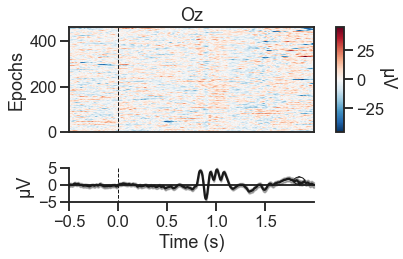

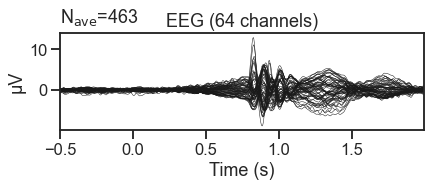

Overwriting existing file.


 83%|███████████████████████████████████       | 20/24 [21:21<04:04, 61.04s/it]

Currently on ppn  20
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_20.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4175871  =      0.000 ...  2039.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 28.4s.
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['T7', 'AF8']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
8 bad epochs dropped
472 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


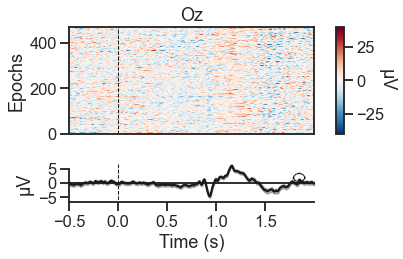

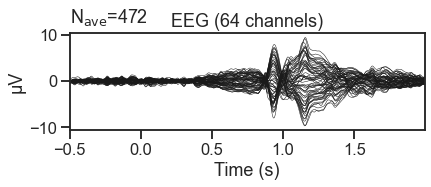

Overwriting existing file.


 88%|████████████████████████████████████▊     | 21/24 [22:24<03:04, 61.49s/it]

Currently on ppn  21
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_21.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4091903  =      0.000 ...  1998.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 25.1s.
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecti

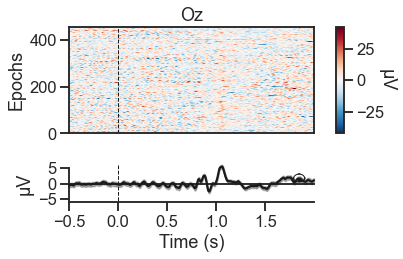

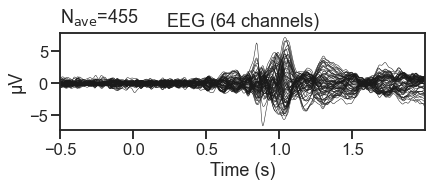

Overwriting existing file.


 92%|██████████████████████████████████████▌   | 22/24 [23:22<02:00, 60.48s/it]

Currently on ppn  22
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_22.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4196351  =      0.000 ...  2049.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 33.1s.
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['F7', 'FT7', 'FC5', 'AF8', 'F8', 'FT8', 'FC6']
    Rejecting  epoch based on EEG : ['F7', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['F7']
16 bad epochs dropped
464 matching events found
No baseline correction applied
Not setting metadata
0 projection items acti

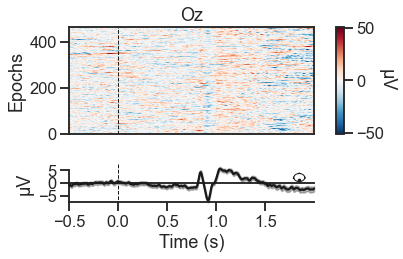

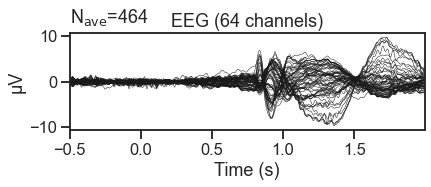

Overwriting existing file.


 96%|████████████████████████████████████████▎ | 23/24 [24:32<01:03, 63.42s/it]

Currently on ppn  23
Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_23.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4147199  =      0.000 ...  2025.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowe

<ipython-input-12-a6a0fd68a231>:77: RuntimeWarning: SVD error (SVD did not converge), attempting to use GESVD instead of GESDD
  ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)


Selecting by number: 30 components
Fitting ICA took 27.9s.
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['P10']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AFz']
    Rejecting  epoch based on EEG : ['AFz']
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'AF4', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'C5', 'P9', 'AF4', 'F8']
    Rejecting  epoch based on EEG : ['AF7', 'AF3', 'F3', 'F5', 'F7', 'FT7', 'T7', 'P9', 'AF8', 'AF4', 'F4', 'F6', 'F8', 'FT8']
    Rejecting  epoch based on EEG : ['AF7', 'FT7', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AF8', 'AF4', 'AFz', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', '

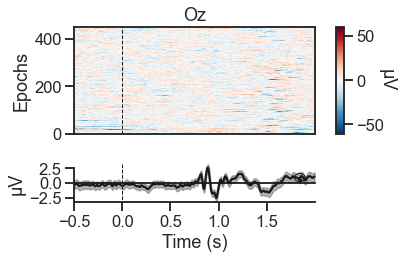

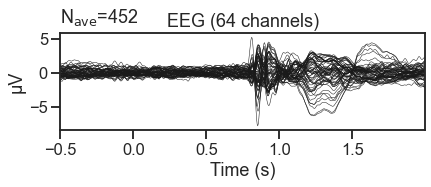

Overwriting existing file.


100%|██████████████████████████████████████████| 24/24 [25:38<00:00, 64.09s/it]


In [12]:
icas_from_all_data=list()

for p in tqdm(range(0,len(EEG_files))): #(0,len(EEG_files))):
    print('Currently on ppn ', p)
    eeg=glob.glob(data_path+'ERP_Flanker_sub_'+str(p)+'.bdf')
    #if p in excluded: #commented to keep participant indices constant during ICA.  
    #    continue

    # read in data, referenced to mastoids
    raw = mne.io.read_raw_bdf(eeg[0], #eog = ['EXG5'], 
                              exclude=['L_EOG', 'R_EOG', 'A_EOG', 'B_EOG', 'EXG7', 'EXG8', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG6', 
                                'EXG5', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'
                                              ],preload=True)
    
    raw.set_eeg_reference('average') # average as ref    
    raw.set_montage(montage)
    
    pick=raw.info['ch_names'][0:65]
    print(pick)
    
    #remove all external electrodes
    raw_wo_ext = raw.copy().pick_channels(pick)
    
    # bandpass filter at 0.5-30Hz
    raw_wo_ext.filter(l_freq=1.,h_freq=30.0)
    
    # identify condition triggers - ignore all response triggers
    events = mne.find_events(raw_wo_ext, stim_channel='Status')
    all_events = mne.pick_events(events, include=[65291,  65292,  65301,  65302,  65311,  65312, 65530])
    eventcodes = mne.pick_events(events, include=[65291,  65292,  65301,  65302,  65311,  65312])
   
    print("eventcodes: ", len(eventcodes))
    #print(eventcodes[:,2])
    metadata = {'eventcodes':eventcodes[:,2]}
    metadata = pd.DataFrame(metadata)
    
    df=pd.read_csv('E:/Projects/2020_reading/Flankers/Results/subject-'+ str(p)+'.csv', sep=',', header=0)
    df=df[['avg_rt','correct', 'flanker_type', 'lexicality','response_time', 'target']] # remove the strange NAN columns etc
    #df.head(10)
    metadata[['correct','flanker_type', 'lexicality']] = df[['correct', 'flanker_type', 'lexicality']]
    
    events2 = mne.pick_events(events, include=[65530])

    print(len(events2))
    print(len(metadata))
    #event_dict = {'no/word': 65311, 'repetition/word': 65291, 'unrelated/word': 65301, 'no/nonword': 65312, 'repetition/nonword': 65292, 'unrelated/nonword': 65302}
    
    
    # epoch data
    epochs = mne.Epochs(raw_wo_ext, events2, tmin=-.5, tmax=2,
                     proj=False, baseline=None,
                     preload=True, 
                     #reject=None,
                     #reject=dict(eeg=180e-6),
                     #reject_by_annotation=False
                   )
    
    if all_events[0,2] == 65530: 
        if len(events2)==491:
            epochs.drop(np.array([0,1,2,3,4,5,6,7,8,9,10]), reason='practice')
            metadata.drop(metadata.index[[0,1,2,3,4,5,6,7,8,9]],inplace=True)
        elif len(events2)==492:
            epochs.drop(np.array([0,1,2,3,4,5,6,7,8,9,10,11]), reason='practice')
            metadata.drop(metadata.index[[0,1,2,3,4,5,6,7,8,9,10]], inplace=True)
    else: 
        if len(events2)==491:
            epochs.drop(np.array([0,1,2,3,4,5,6,7,8,9,10]), reason='practice')
            metadata.drop(metadata.index[[0,1,2,3,4,5,6,7,8,9,10]],inplace=True)
        elif len(events2)==492:
            epochs.drop(np.array([0,1,2,3,4,5,6,7,8,9,10,11]), reason='practice')
            metadata.drop(metadata.index[[0,1,2,3,4,5,6,7,8,9,10,11]], inplace=True)

    epochs.metadata=metadata
    epochs.resample(256, npad='auto')
    
    # run ICA
    ica = mne.preprocessing.ICA(method='fastica', max_iter=100000, n_components=30).fit(epochs)    
    icas_from_all_data.append(ica)

    epochs.drop_bad(reject=dict(eeg=180e-6))
    epochs.plot_image(picks=['Oz'])
    epochs.average().plot()
    epochs.save('E:/Projects/2020_reading/Flankers/EEG_preprocessed/' + 'pp_' + str(p) + '__beforeICA-epo.fif', overwrite=True)

    del raw, raw_wo_ext, events, events2, epochs#, ica
    

In [13]:
with open('E:/Projects/2020_reading/Flankers/ica_all_data', 'wb') as f:
    pickle.dump(icas_from_all_data, f)

In [14]:
with open('E:/Projects/2020_reading/Flankers/ica_all_data', 'rb') as f:
    icas_from_all_data = pickle.load(f)

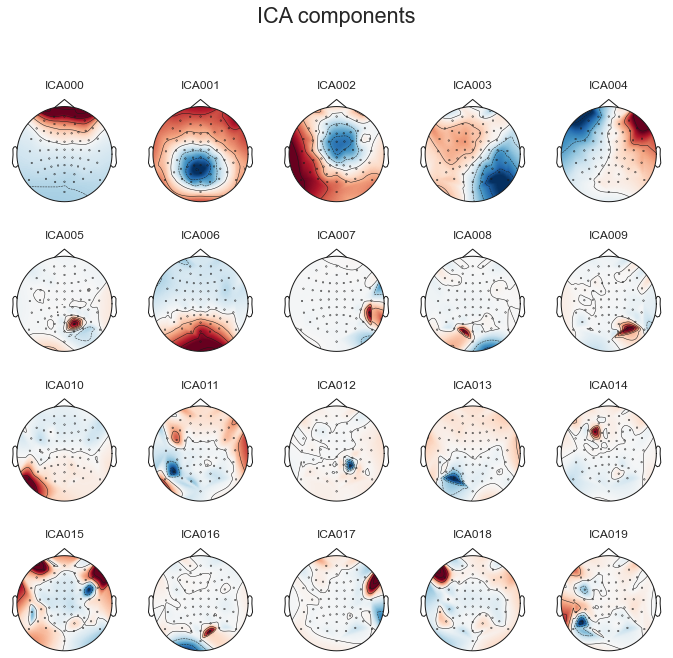

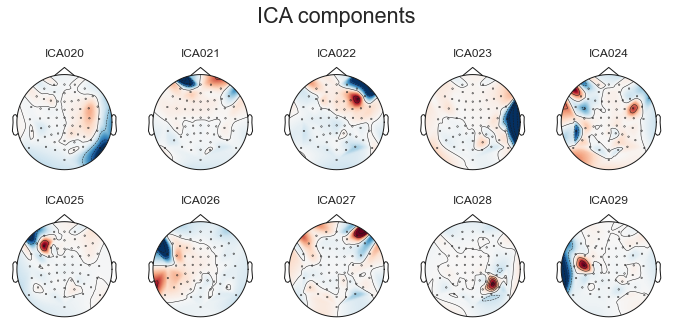

[<Figure size 702x678.24 with 20 Axes>, <Figure size 702x339.12 with 10 Axes>]

In [15]:
pp=10
reference_ica = icas_from_all_data[pp]
reference_ica.plot_components()

In [16]:
template = (10, 0)

Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


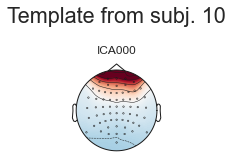

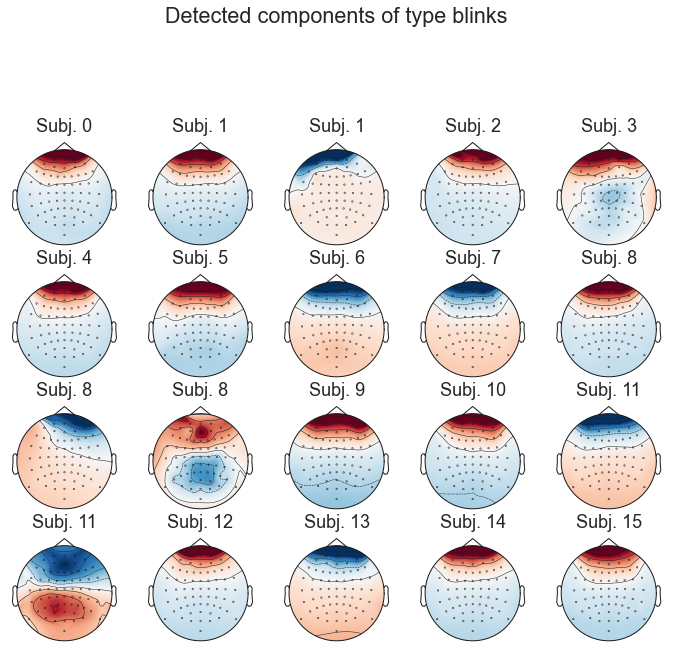

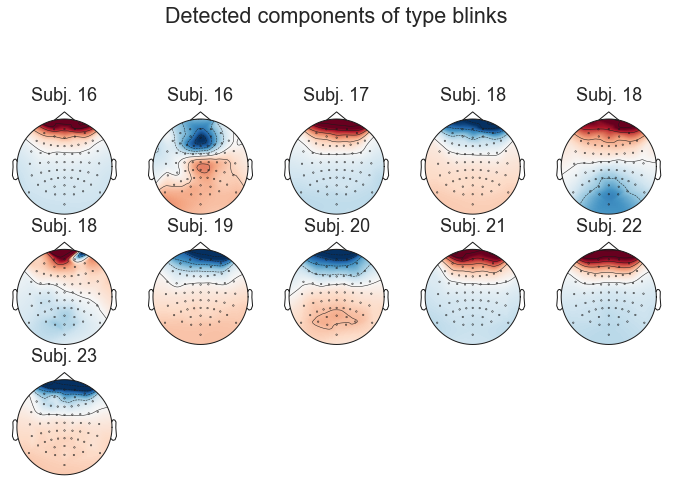

In [17]:
fig_template, fig_detected = mne.preprocessing.corrmap(icas_from_all_data, template=template, label='blinks',
                                                      show=False, threshold=.8)

In [18]:
template = (10, 4)

Median correlation with constructed map: 0.952
Displaying selected ICs per subject.
No maps selected for subjects [0, 2, 3, 6, 7, 8, 9, 12, 14, 15, 18, 23], consider a more liberal threshold.


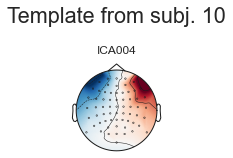

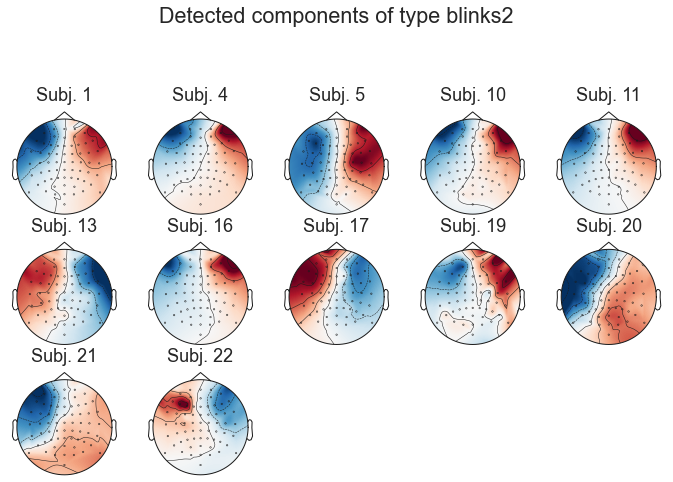

In [19]:
fig_template, fig_detected = mne.preprocessing.corrmap(icas_from_all_data, template=template, label='blinks2',
                                                      show=False, threshold=.8)

  0%|                                                                                                                                                                                                                                                                                                | 0/24 [00:00<?, ?it/s]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_0.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4239359  =      0.000 ...  2070.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

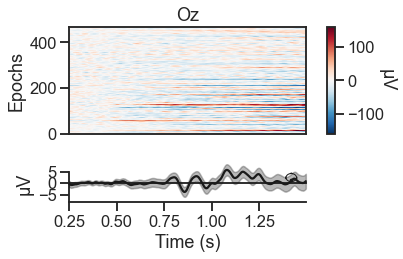

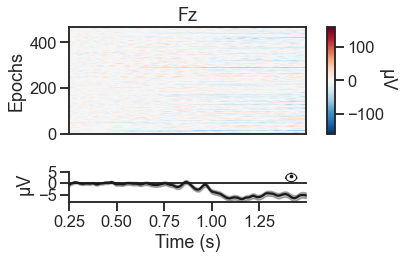

  4%|███████████▋                                                                                                                                                                                                                                                                            | 1/24 [00:42<16:16, 42.44s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4397055  =      0.000 ...  2147.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

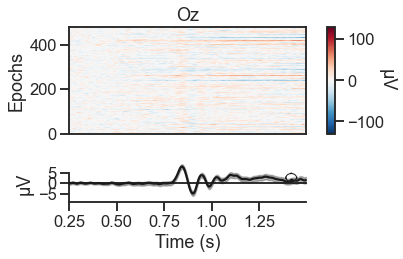

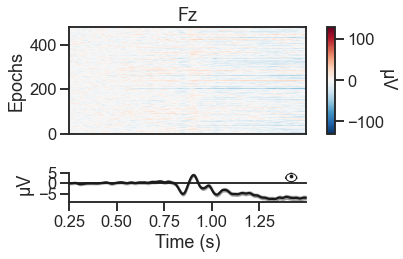

  8%|███████████████████████▎                                                                                                                                                                                                                                                                | 2/24 [01:22<15:20, 41.82s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4202495  =      0.000 ...  2052.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

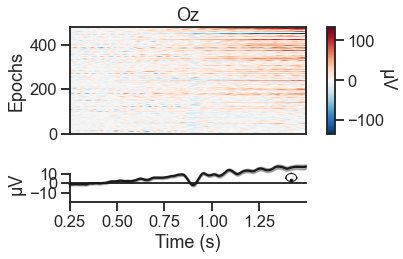

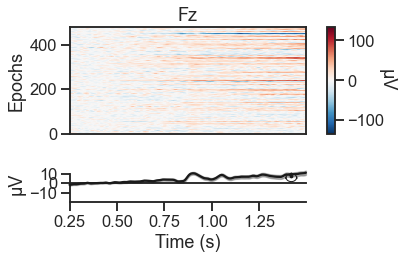

 12%|███████████████████████████████████                                                                                                                                                                                                                                                     | 3/24 [02:00<14:14, 40.69s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_3.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4218879  =      0.000 ...  2060.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

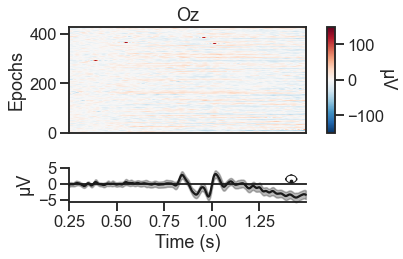

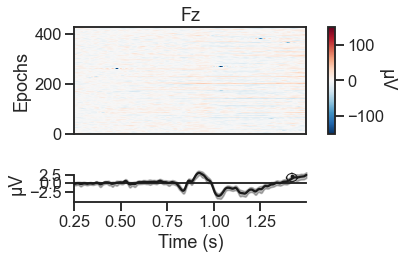

 17%|██████████████████████████████████████████████▋                                                                                                                                                                                                                                         | 4/24 [02:40<13:24, 40.23s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_4.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4261887  =      0.000 ...  2081.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

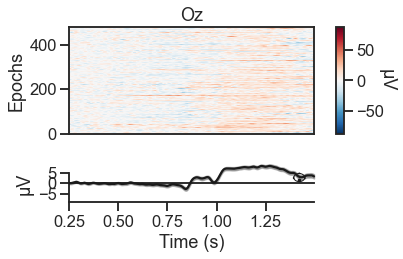

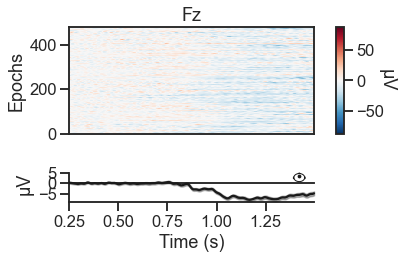

 21%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 5/24 [03:20<12:45, 40.31s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_6.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4288511  =      0.000 ...  2094.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

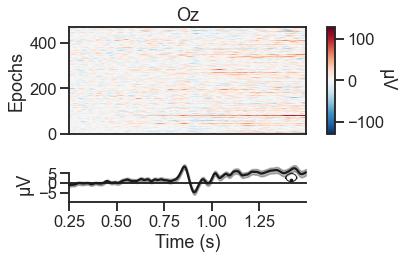

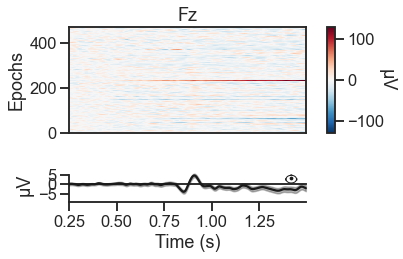

 29%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                      | 7/24 [03:58<09:37, 33.95s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_8.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4255743  =      0.000 ...  2078.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

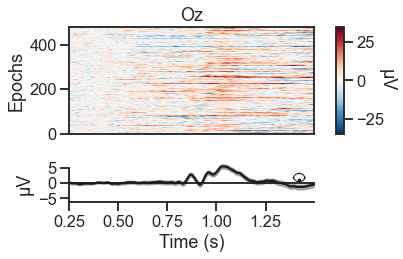

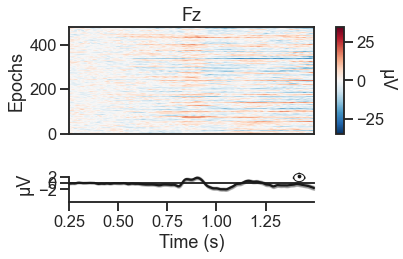

 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 9/24 [04:37<07:22, 29.51s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_9.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4128767  =      0.000 ...  2016.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

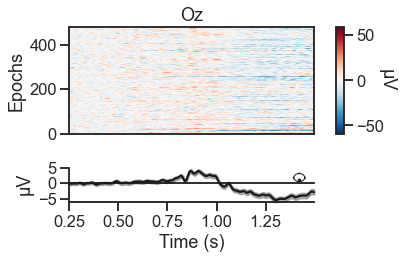

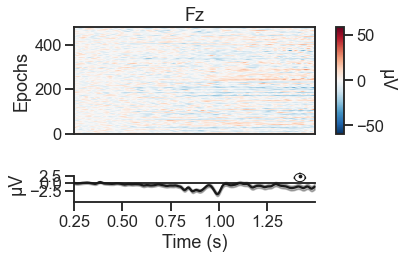

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                  | 10/24 [05:16<07:35, 32.54s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_10.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4222975  =      0.000 ...  2062.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

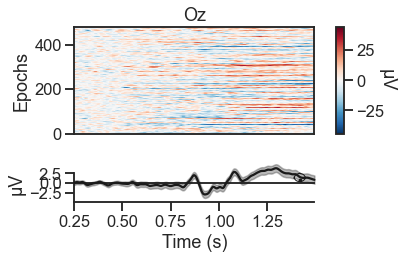

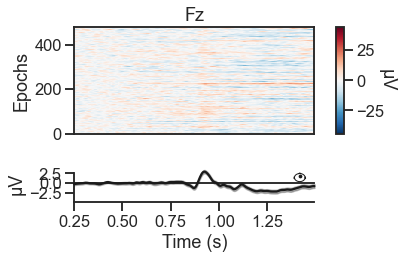

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 11/24 [06:00<07:48, 36.04s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_12.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4155391  =      0.000 ...  2029.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

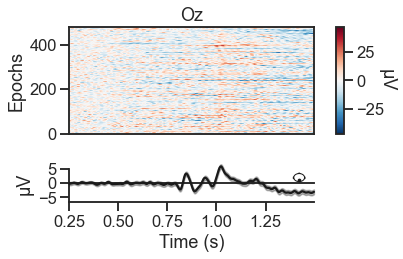

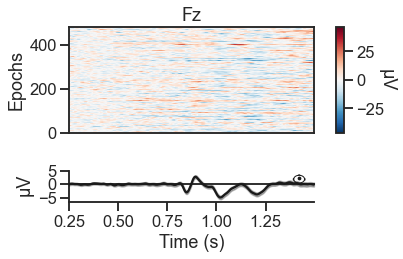

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 13/24 [06:40<05:42, 31.14s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_13.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4118527  =      0.000 ...  2011.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

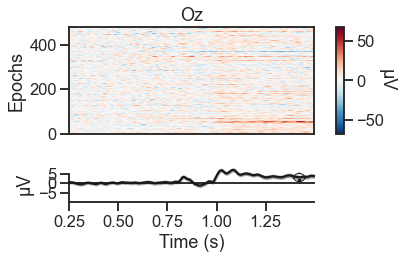

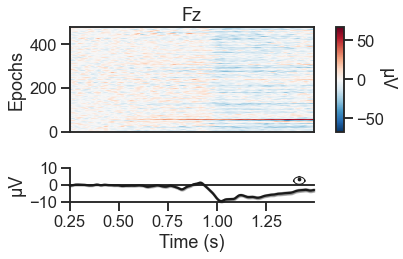

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 14/24 [07:20<05:37, 33.75s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_14.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4276223  =      0.000 ...  2088.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

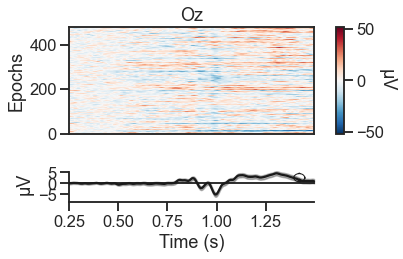

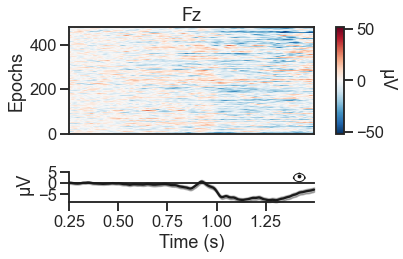

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 15/24 [08:00<05:20, 35.66s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_15.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4249599  =      0.000 ...  2075.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

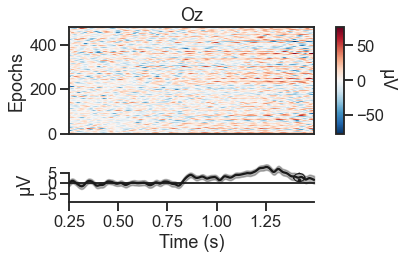

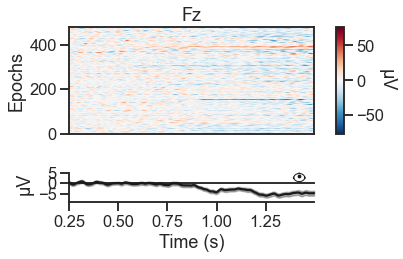

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 16/24 [08:44<05:05, 38.22s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_16.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4188159  =      0.000 ...  2045.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

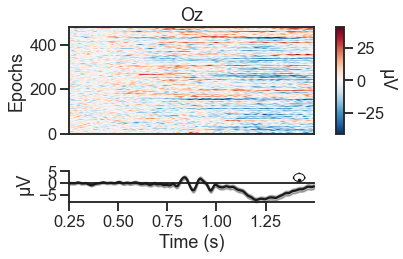

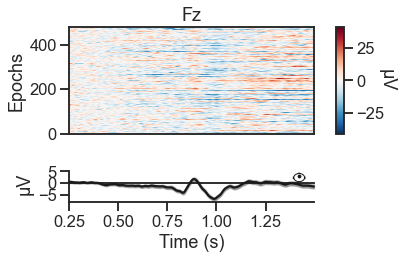

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 17/24 [09:27<04:37, 39.60s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_17.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4239359  =      0.000 ...  2070.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

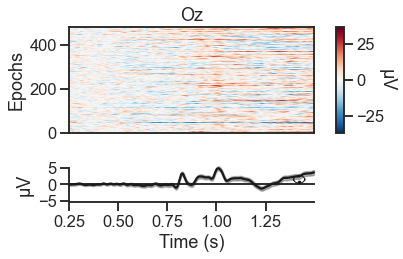

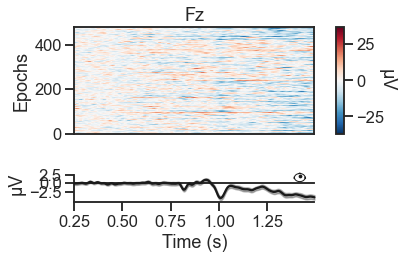

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 18/24 [10:07<03:58, 39.68s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_18.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4218879  =      0.000 ...  2060.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

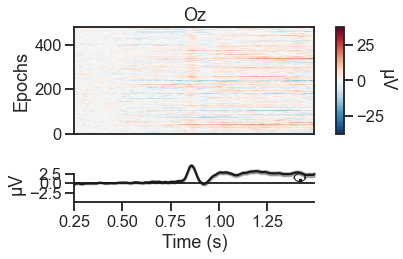

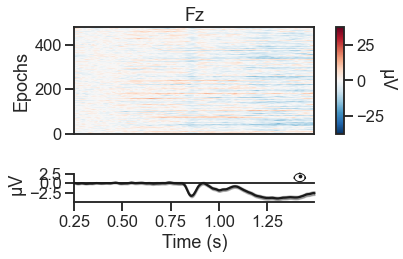

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 19/24 [10:46<03:18, 39.61s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_19.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4141055  =      0.000 ...  2022.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

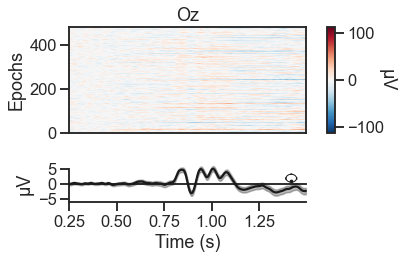

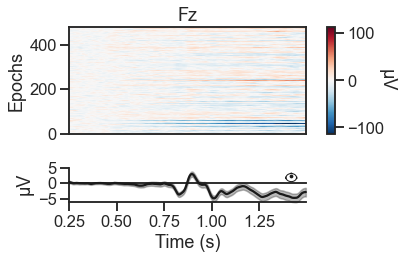

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 20/24 [11:24<02:36, 39.06s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_20.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4175871  =      0.000 ...  2039.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

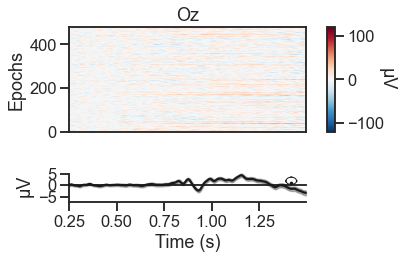

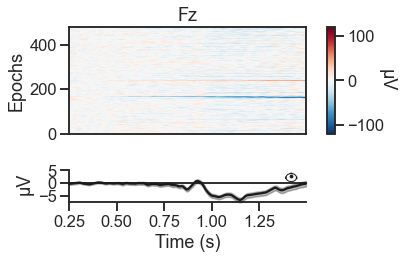

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 21/24 [12:01<01:55, 38.57s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_21.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4091903  =      0.000 ...  1998.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

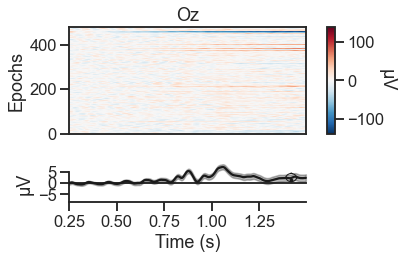

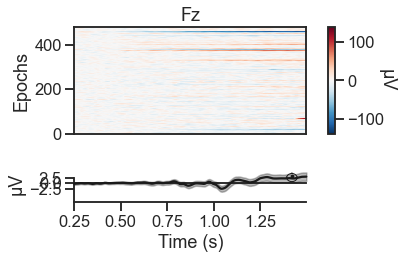

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 22/24 [12:38<01:15, 37.92s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_22.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4196351  =      0.000 ...  2049.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

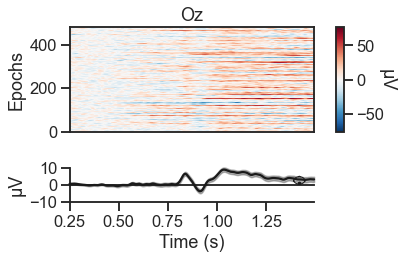

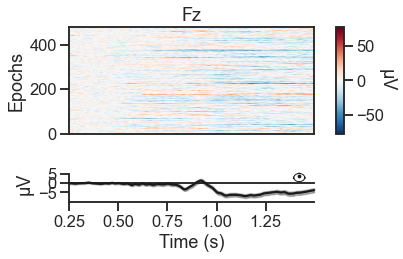

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 23/24 [13:15<00:37, 37.85s/it]

Extracting EDF parameters from E:\Projects\2020_reading\Flankers\EEG Results\ERP_Flanker_sub_23.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4147199  =      0.000 ...  2025.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

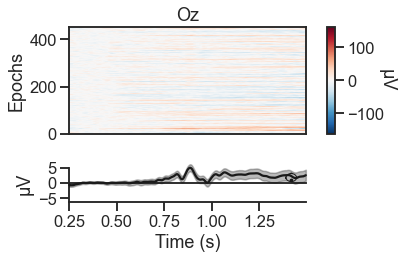

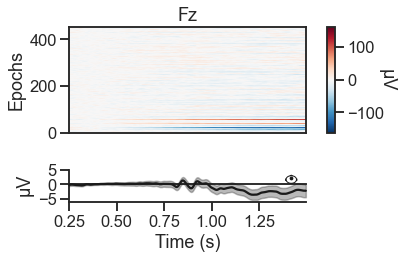

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [13:55<00:00, 34.82s/it]


In [95]:
# second loop to apply ica & drop bad epochs
for p in tqdm(range(0,len(EEG_files))):
    
    if p in excluded:  
        continue
        
    eeg=glob.glob(data_path+'ERP_Flanker_sub_'+str(p)+'.bdf')

    # read in data, referenced to mastoids
    raw = mne.io.read_raw_bdf(eeg[0], #eog = ['EXG5'], 
                              exclude=['L_EOG', 'R_EOG', 'A_EOG', 'B_EOG', 'EXG7', 'EXG8', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG6', 
                                'EXG5', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'
                                              ],preload=True)
    
    raw.set_eeg_reference('average') # average as ref    
    raw.set_montage(montage)
    
    pick=raw.info['ch_names'][0:65]
    print(pick)
    
    #remove all external electrodes
    raw_wo_ext = raw.copy().pick_channels(pick)
    
    # bandpass filter at 0.1-30Hz
    raw_wo_ext.filter(l_freq=.1, h_freq=30.0)
    
    # load precomputed ICA -- p-1 because loop starts at 1 (no zero-indexing)
    ica = icas_from_all_data[p]
    
    # load blink component found with corrmap
    blink = icas_from_all_data[p].labels_['blinks']
    blink2 = icas_from_all_data[p].labels_['blinks2']   
    
    # remove blink component -- extend because sometimes there is more than 1 component 
    ica.exclude.extend(blink)
    ica.exclude.extend(blink2)
    ica.apply(raw_wo_ext)
    
    
    # identify condition triggers - ignore all response triggers
        # identify condition triggers - ignore all response triggers
    events = mne.find_events(raw_wo_ext, stim_channel='Status')
    all_events = mne.pick_events(events, include=[65291,  65292,  65301,  65302,  65311,  65312, 65530])
    eventcodes = mne.pick_events(events, include=[65291,  65292,  65301,  65302,  65311,  65312])
   
    print("eventcodes: ", len(eventcodes))
    #print(eventcodes[:,2])
    metadata = {'eventcodes':eventcodes[:,2]}
    metadata = pd.DataFrame(metadata)
    
    events2 = mne.pick_events(events, include=[65530])

    print(len(events2))
    print(len(metadata))
    #event_dict = {'no/word': 65311, 'repetition/word': 65291, 'unrelated/word': 65301, 'no/nonword': 65312, 'repetition/nonword': 65292, 'unrelated/nonword': 65302}
    
    # epoch data
    epochs = mne.Epochs(raw_wo_ext, events2, tmin=.25, tmax=1.5,
                     proj=False, baseline=(.25, .5),
                     preload=True, 
                     reject=None,
                     picks=["Fz", "POz", "Cz", "Oz"]
                     #reject=dict(eeg=180e-6)
                   )
    
    if all_events[0,2] == 65530: 
        if len(events2)==491:
            epochs.drop(np.array([0,1,2,3,4,5,6,7,8,9,10]), reason='practice')
            metadata.drop(metadata.index[[0,1,2,3,4,5,6,7,8,9]],inplace=True)
        elif len(events2)==492:
            epochs.drop(np.array([0,1,2,3,4,5,6,7,8,9,10,11]), reason='practice')
            metadata.drop(metadata.index[[0,1,2,3,4,5,6,7,8,9,10]], inplace=True)
    else: 
        if len(events2)==491:
            epochs.drop(np.array([0,1,2,3,4,5,6,7,8,9,10]), reason='practice')
            metadata.drop(metadata.index[[0,1,2,3,4,5,6,7,8,9,10]],inplace=True)
        elif len(events2)==492:
            epochs.drop(np.array([0,1,2,3,4,5,6,7,8,9,10,11]), reason='practice')
            metadata.drop(metadata.index[[0,1,2,3,4,5,6,7,8,9,10,11]], inplace=True)
            
    df=pd.read_csv('E:/Projects/2020_reading/Flankers/Results/subject-'+ str(p)+'.csv', sep=',', header=0)
    df=df[['avg_rt','correct', 'flanker_type', 'lexicality','response_time', 'target']] # remove the strange NAN columns etc
    print(len(df))
    metadata.reset_index(inplace=True)
    metadata[['correct','flanker_type', 'lexicality','target']] = df[['correct', 'flanker_type', 'lexicality','target']]

    
    epochs.metadata=metadata
    print(metadata)
    
    epochs.resample(256, npad='auto')
    epochs.drop_bad(reject=dict(eeg=180e-6))

    
    epochs.plot_image(picks=['Oz', 'Fz'])
   
    epochs.save('E:/Projects/2020_reading/Flankers/EEG_preprocessed/' + 'pp_' + str(p) + '_1211_picks_baseline-epo.fif', overwrite=True)
    del ica, epochs

### Plot 


In [548]:
data_path = "E:/Projects/2020_reading/Flankers/EEG Results/"
EEG_files = glob.glob(data_path+'*.bdf') # returns 40 EEG files
print('there are %i EEG files' %len(EEG_files))

there are 24 EEG files


In [549]:
from scipy.io import loadmat
excluded = [5, 7,11 ] #list of participants to exclude 
all_subj = []
df = pd.DataFrame()

# selection of electrodes 
elecs=['Fz','Cz','POz']
    
for electrode in elecs: 
    for p in tqdm(range(0,len(EEG_files))):
        
        if p in excluded:  
            continue

        epochs = mne.read_epochs('E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_' + str(p) + '_1211_picks_baseline-epo.fif', verbose=None)
        data = np.squeeze(epochs.get_data(picks=electrode))     
        cond_nr = epochs.metadata['eventcodes']
        stimulus = epochs.metadata['target']
        corr = epochs.metadata['correct']

        cond = pd.DataFrame(cond_nr)
        cond.reset_index(drop=True, inplace=True)
                
        stim = pd.DataFrame(stimulus)
        stim.reset_index(drop=True, inplace=True)
        
        cor = pd.DataFrame(corr)
        cor.reset_index(drop=True, inplace=True)
    
        df = pd.DataFrame(data)
        df.reset_index(drop=True,inplace=True)
        df['channel_id'] = electrode
        df['subj_idx'] = p
        df['condition'] = cond['eventcodes']
        df['stimulus'] = stim['target']
        df['correct'] = cor['correct']
        df = df[df['correct']== 1]
        
        df = df.melt(id_vars=['subj_idx','channel_id','condition','stimulus', 'correct'], var_name='timepoint')
    
        all_subj.append(df)
        
data = pd.concat(all_subj)        
data.head(10)


  0%|                                                                                                                                                                                                                                                                                                | 0/24 [00:00<?, ?it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_0_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
468 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


  4%|███████████▋                                                                                                                                                                                                                                                                            | 1/24 [00:00<00:03,  5.83it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_1_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_2_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
479 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 12%|███████████████████████████████████                                                                                                                                                                                                                                                     | 3/24 [00:00<00:03,  6.97it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_3_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
428 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_4_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 21%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 5/24 [00:00<00:02,  8.17it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_6_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
472 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_8_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 9/24 [00:00<00:01, 10.44it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_9_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_10_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 11/24 [00:00<00:01, 11.42it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_12_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_13_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 14/24 [00:00<00:00, 13.34it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_14_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_15_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 16/24 [00:01<00:00, 13.93it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_16_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_17_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 18/24 [00:01<00:00, 14.18it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_18_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_19_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 20/24 [00:01<00:00, 13.93it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_20_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_21_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
479 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 22/24 [00:01<00:00, 13.91it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_22_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_23_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
453 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


  0%|                                                                                                                                                                                                                                                                                                | 0/24 [00:00<?, ?it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_0_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
468 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_1_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


  8%|███████████████████████▎                                                                                                                                                                                                                                                                | 2/24 [00:00<00:01, 16.34it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_2_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
479 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_3_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
428 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_4_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns


 21%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 5/24 [00:00<00:01, 17.59it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_6_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
472 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_8_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 9/24 [00:00<00:00, 21.04it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_9_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_10_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_12_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 column

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 13/24 [00:00<00:00, 22.81it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_13_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_14_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_15_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 colum

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 16/24 [00:00<00:00, 21.80it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_16_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_17_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_18_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 colum

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 19/24 [00:00<00:00, 21.29it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_19_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_20_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_21_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
479 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 colum

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 22/24 [00:00<00:00, 20.81it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_22_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_23_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
453 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


  0%|                                                                                                                                                                                                                                                                                                | 0/24 [00:00<?, ?it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_0_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
468 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_1_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


  8%|███████████████████████▎                                                                                                                                                                                                                                                                | 2/24 [00:00<00:01, 19.87it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_2_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
479 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_3_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
428 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 17%|██████████████████████████████████████████████▋                                                                                                                                                                                                                                         | 4/24 [00:00<00:01, 19.40it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_4_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_6_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
472 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 29%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                      | 7/24 [00:00<00:00, 21.11it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_8_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_9_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                  | 10/24 [00:00<00:00, 23.16it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_10_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_12_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 13/24 [00:00<00:00, 24.29it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_13_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_14_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_15_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 colum

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 16/24 [00:00<00:00, 21.89it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_16_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_17_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_18_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 colum

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 19/24 [00:00<00:00, 19.70it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_19_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_20_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 21/24 [00:01<00:00, 18.42it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_21_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
479 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_22_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 23/24 [00:01<00:00, 18.04it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_23_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
453 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 20.18it/s]


subj_idx channel_id  condition        stimulus  correct timepoint  \
0         0         Fz      65311           lent         1         0   
1         0         Fz      65301  ment drap ment        1         0   
2         0         Fz      65302  sabe cofi sabe        1         0   
3         0         Fz      65292  uise uise uise        1         0   
4         0         Fz      65291  dire dire dire        1         0   
5         0         Fz      65302  flin uter flin        1         0   
6         0         Fz      65291  deux deux deux        1         0   
7         0         Fz      65311           oeuf         1         0   
8         0         Fz      65291  amer amer amer        1         0   
9         0         Fz      65302  momb rers momb        1         0   

          value  
0 -1.231276e-05  
1 -3.148658e-07  
2 -3.417395e-06  
3  3.300677e-08  
4 -3.652495e-06  
5 -6.088457e-06  
6 -1.388122e-05  
7  5.620591e-07  
8  6.982711e-06  
9 -2.120360e-05

In [550]:
#event_dict = {'no/word': 65311, 'repetition/word': 65291, 'unrelated/word': 65301, 
word_conditions = [65311,65291,65301]

data2plot = data[data['condition'].isin(word_conditions)].copy(deep=True)
data2plot['inverse_value']=data2plot['value']*-1e6
data2plot['value'] = data2plot['value']*1e6
data2plot['time']=data2plot['timepoint'].astype(int)*(1.25/320)-0.4
data2plot['stimulus'] = data2plot['stimulus'].str.strip()

#data2plot = data2plot[data2plot[timepoint]>64]

data2plot.head(100)

subj_idx channel_id  condition        stimulus  correct timepoint  \
0           0         Fz      65311            lent        1         0   
1           0         Fz      65301  ment drap ment        1         0   
4           0         Fz      65291  dire dire dire        1         0   
6           0         Fz      65291  deux deux deux        1         0   
7           0         Fz      65311            oeuf        1         0   
..        ...        ...        ...             ...      ...       ...   
207         0         Fz      65311            main        1         0   
210         0         Fz      65311            noir        1         0   
211         0         Fz      65291  aube aube aube        1         0   
214         0         Fz      65291  apte apte apte        1         0   
215         0         Fz      65311            ment        1         0   

         value  inverse_value  time  
0   -12.312758      12.312758  -0.4  
1    -0.314866       0.314866  -0.4  
4    -3.652495       3.652495  -0.4  
6   -13.881223      13.881223  -0.4  
7     0.562059      -0.562059  -0.4  
..         ...            ...   ...  
207   6.119733      -6.119733  -0.4  
210  -2.392353       2.392353  -0.4  
211   3.149590      -3.149590  -0.4  
214  -1.074902       1.074902  -0.4  
215 -11.885448      11.885448  -0.4  

[100 rows x 9 columns]

In [253]:
data2plot.subj_idx.unique()

array([ 0,  1,  2,  3,  4,  6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23], dtype=int64)

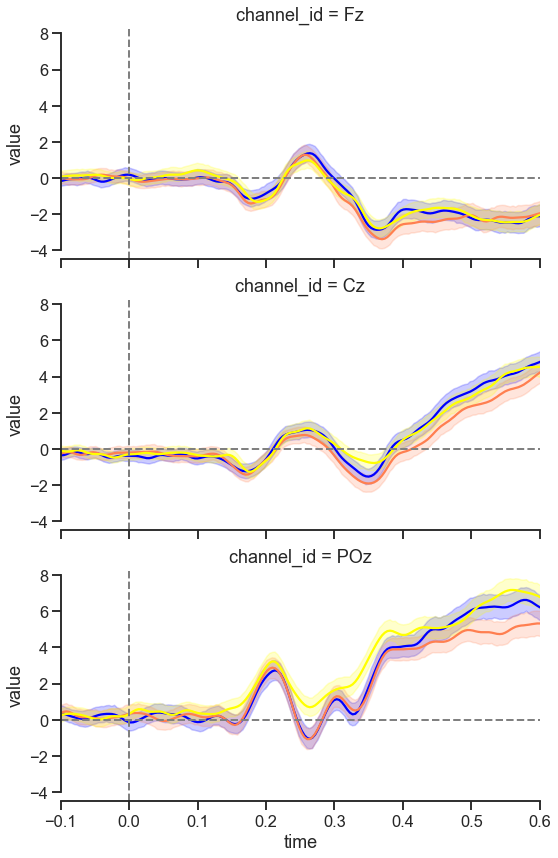

In [117]:
# Plot the responses for different events and regions
erp_plot = sns.relplot(x="time", y="value",ci=95,
             hue="condition",row="channel_id",kind="line",# style="event",
            palette = ['blue', 'coral','yellow'],legend=False,
             data=data2plot)

erp_plot.set(xlim=(-0.1, 0.6))
erp_plot.set(xticks=[-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
erp_plot.fig.set_figwidth(8.27)
erp_plot.fig.set_figheight(11.7)


for ax in erp_plot.axes.flat:
    ax.axvline(0, ls='--', linewidth=2, color="gray")
    ax.axhline(0, ls='--', linewidth=2, color="gray")

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

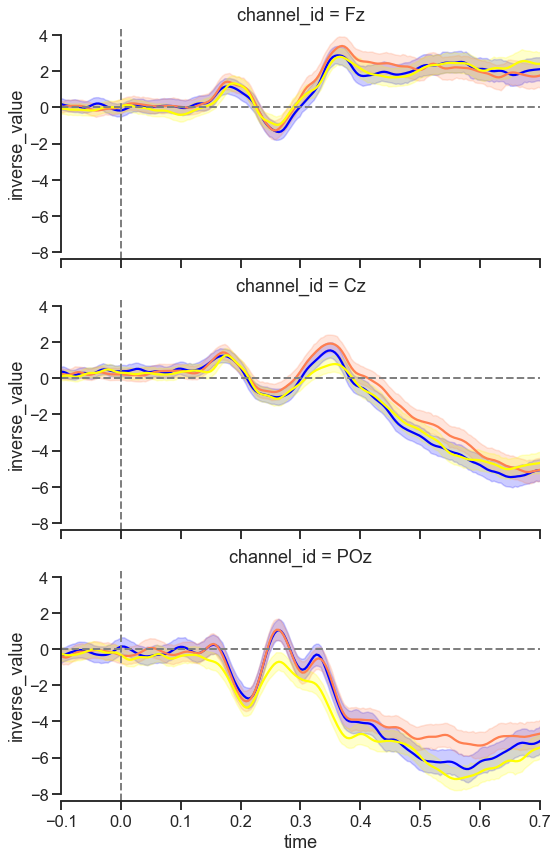

In [334]:
# Plot inverse, for comparison with original figure
erp_plot = sns.relplot(x="time", y="inverse_value",ci=95,
             hue="condition",row="channel_id",kind="line",# style="event",
            palette = ['blue', 'coral','yellow'],legend=False,
             data=data2plot)

erp_plot.set(xlim=(-0.1, 0.7))
erp_plot.set(xticks=[-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
erp_plot.fig.set_figwidth(8.27)
erp_plot.fig.set_figheight(11.7)


for ax in erp_plot.axes.flat:
    ax.axvline(0, ls='--', linewidth=2, color="gray")
    ax.axhline(0, ls='--', linewidth=2, color="gray")

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

In [565]:
data2plot.head(3)

subj_idx channel_id  condition        stimulus  correct timepoint  \
0         0         Fz      65311            lent        1         0   
1         0         Fz      65301  ment drap ment        1         0   
4         0         Fz      65291  dire dire dire        1         0   

       value  inverse_value  time  
0 -12.312758      12.312758  -0.4  
1  -0.314866       0.314866  -0.4  
4  -3.652495       3.652495  -0.4

## plot with OB1 lexicon activity

In [611]:
df = pd.read_pickle('E:/Projects/2020_reading/Flankerlexicon.pkl')
bindict = dict(zip(df['stimulus'], df['bin']))
actdict = dict(zip(df['stimulus'], df['lexicon activity per cycle']))

lexicon2plot = data2plot.copy(deep=True)

lexicon2plot['bin'] = lexicon2plot['stimulus'].map(bindict)
lexicon2plot['OB1 activity'] = lexicon2plot['stimulus'].map(actdict)


lexiconN250 = lexicon2plot[(lexicon2plot['time']>.175) & (lexicon2plot['time']< .25)].copy(deep=True)
lexiconN400 = lexicon2plot[(lexicon2plot['time']>.25) & (lexicon2plot['time']< .45)].copy(deep=True)
lexiconP600 = lexicon2plot[(lexicon2plot['time']>.59) & (lexicon2plot['time']< .61)].copy(deep=True)

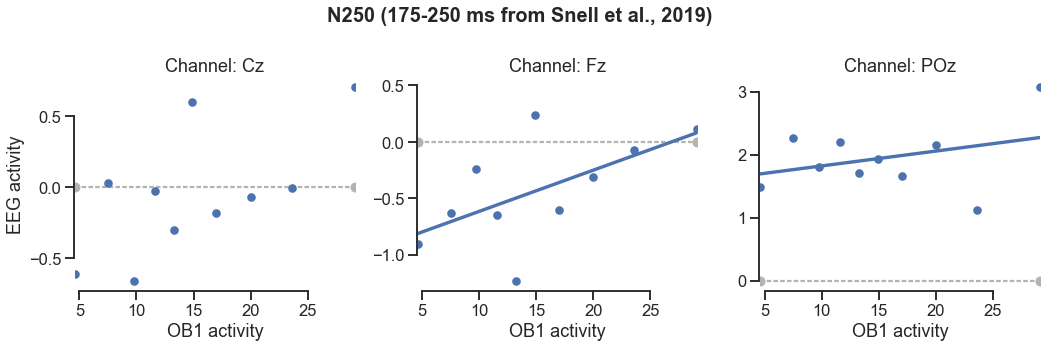

In [612]:
# Show the results of a linear regression within each dataset
sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")

g = sns.lmplot(x="OB1 activity", y="value", col="channel_id", data=lexiconN250.groupby(['bin', 'channel_id'],as_index=False).mean(),
           col_order=['Cz', 'Fz', 'POz'],#col_wrap=2, 
            palette="muted", height=5 ,x_estimator=np.mean,fit_reg=True,sharey=False, ci=None,
           scatter_kws={"s": 50, "alpha": 1})
# g.set(xticks=[0,2,4,6,8])
g.fig.suptitle("N250 (175-250 ms from Snell et al., 2019)", size=20, weight="bold")


(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("OB1 activity", "EEG activity")
  .set_titles("Channel: {col_name}")
  .tight_layout(w_pad=1))

sns.despine(offset=0.9, trim=True)

In [620]:
fz = lexiconN250[lexiconN250["channel_id"]=="Fz"].groupby(['bin'],as_index=False).mean().copy(deep=True)
# print(scipy.stats.normaltest(fz['OB1 activity']))
# print(scipy.stats.normaltest(fz['value']))
print(scipy.stats.spearmanr(fz['OB1 activity'], fz['value']))

SpearmanrResult(correlation=0.6121212121212121, pvalue=0.059972142477255234)


In [621]:
cz = lexiconN250[lexiconN250["channel_id"]=="Cz"].groupby(['bin']).mean().copy(deep=True)
scipy.stats.pearsonr(cz['OB1 activity'], cz['value'])

(0.648531508446594, 0.0425202707852436)

In [622]:
poz = lexiconN250[lexiconN250["channel_id"]=="POz"].groupby(['bin']).mean().copy(deep=True)
scipy.stats.pearsonr(poz['OB1 activity'], poz['value'])

(0.3339446134679742, 0.3456550121748635)

### N400

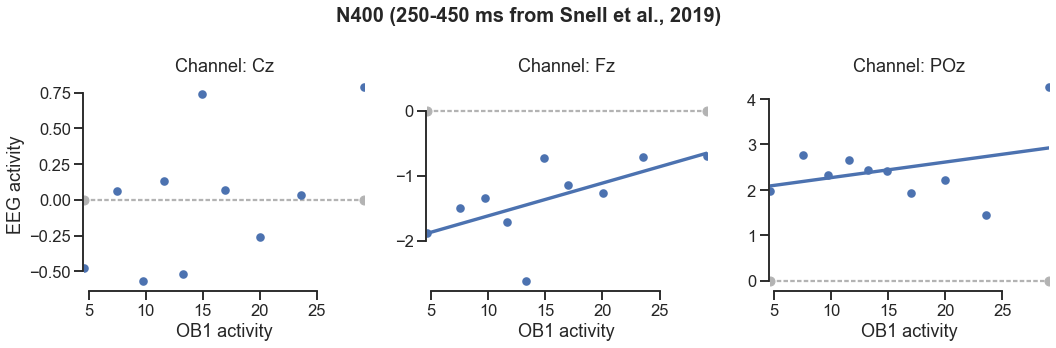

In [623]:
# Show the results of a linear regression within each dataset
sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")

g = sns.lmplot(x="OB1 activity", y="value", col="channel_id", data=lexiconN400.groupby(['bin', 'channel_id'],as_index=False).mean(),
           col_order=['Cz', 'Fz', 'POz'],#col_wrap=2, 
            palette="muted", height=5 ,x_estimator=np.mean,fit_reg=True,sharey=False, ci=None,
           scatter_kws={"s": 50, "alpha": 1})
# g.set(xticks=[0,2,4,6,8,10])
g.fig.suptitle("N400 (250-450 ms from Snell et al., 2019)", size=20, weight="bold")


(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("OB1 activity", "EEG activity")
  .set_titles("Channel: {col_name}")
  .tight_layout(w_pad=1))

sns.despine(offset=0.9, trim=True)

In [624]:
fz = lexiconN400[lexiconN400["channel_id"]=="Fz"].groupby(['bin'],as_index=False).mean().copy(deep=True)
scipy.stats.spearmanr(fz['OB1 activity'], fz['value'])

SpearmanrResult(correlation=0.7939393939393938, pvalue=0.0060999233136969115)

In [625]:
cz = lexiconN400[lexiconN400["channel_id"]=="Cz"].groupby(['bin'],as_index=False).mean().copy(deep=True)
scipy.stats.spearmanr(cz['OB1 activity'], cz['value'])

SpearmanrResult(correlation=0.4545454545454545, pvalue=0.186904810349332)

In [626]:
poz = lexiconN400[lexiconN400["channel_id"]=="POz"].groupby(['bin'],as_index=False).mean().copy(deep=True)
scipy.stats.spearmanr(poz['OB1 activity'], poz['value'])

SpearmanrResult(correlation=-0.10303030303030303, pvalue=0.7769984634438898)

#### Our computational model of reading (OB1) reads in 25 ms timesteps. Therefore, downsample the data to 40 Hz: 

In [525]:

from scipy.io import loadmat
from scipy.signal import resample
excluded = [5, 7,11 ] #list of participants to exclude 
all_subj = []
df = pd.DataFrame()

# selection of electrodes - 2 poolings 
elecs=['Fz','Cz','POz']
    
for electrode in elecs: 
    for p in tqdm(range(0,len(EEG_files))):
        
        if p in excluded:  
            continue

        epochs = mne.read_epochs('E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_' + str(p) + '_1211_picks_baseline-epo.fif', verbose=None)
        data = np.squeeze(epochs.get_data(picks=electrode))
        downsampled_data = resample(data, 50,axis=1)
        cond_nr = epochs.metadata['eventcodes']
        cond = pd.DataFrame(cond_nr)
        cond.reset_index(drop=True, inplace=True)
        
        df = pd.DataFrame(downsampled_data)
        df.reset_index(drop=True,inplace=True)
        #print(df.head(10))
        df['channel_id'] = electrode
        df['subj_idx'] = p
        df['condition'] = cond['eventcodes']
        
        print(df.head(10))

        df = df.melt(id_vars=['subj_idx','channel_id','condition'], var_name='timepoint')
    
        all_subj.append(df)
        
data = pd.concat(all_subj)        
print(data.head(10))

#event_dict = {'no/word': 65311, 'repetition/word': 65291, 'unrelated/word': 65301, 
word_conditions = [65311,65291,65301]

data2plot = data[data['condition'].isin(word_conditions)]
data2plot['inverse_value']=data2plot['value']*-1e6
data2plot['time']=data2plot['timepoint']*(1.25/50)-0.40
#data2plot = data2plot[data2plot[timepoint]>64]

data2plot.head(100)

  0%|                                                   | 0/24 [00:00<?, ?it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_0_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
468 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


  4%|█▊                                         | 1/24 [00:00<00:03,  6.33it/s]

          0             1         2             3             4             5  \
0 -0.000004 -1.040798e-05 -0.000004 -3.642709e-06  4.190006e-06 -3.047489e-07   
1 -0.000003  7.893140e-07 -0.000004 -4.721614e-06  2.307614e-06  5.582164e-06   
2 -0.000003  2.876293e-06 -0.000006 -4.117571e-06 -1.283838e-06  1.544354e-06   
3 -0.000017  5.357582e-08  0.000002  2.808058e-06 -4.765997e-07  5.411268e-06   
4  0.000002  7.407557e-08 -0.000002 -5.818322e-06 -8.037503e-06  8.718908e-07   
5 -0.000008 -2.918979e-06 -0.000003 -1.888480e-06  2.475691e-06 -1.950924e-06   
6 -0.000020  1.688457e-06 -0.000004 -4.558711e-07 -2.629883e-06  6.041498e-08   
7  0.000007 -8.165350e-06 -0.000008 -1.412928e-06 -3.298588e-06 -8.528204e-06   
8  0.000001  4.113374e-06  0.000006  4.618190e-06  3.832496e-06 -2.140963e-06   
9 -0.000010 -2.209028e-06  0.000010 -5.970286e-06 -1.006797e-05  4.738502e-07   

              6             7             8             9  ...        43  \
0  5.929474e-07  3.939590e-06  4

 12%|█████▍                                     | 3/24 [00:00<00:02,  7.81it/s]

          0             1             2         3             4             5  \
0  0.000006  1.277666e-05  4.217668e-06 -0.000003 -8.088408e-06 -4.627748e-06   
1 -0.000002 -3.169394e-06  9.010390e-06  0.000002 -9.291207e-07  3.785967e-06   
2  0.000009 -5.392994e-06 -3.726283e-07  0.000005  2.001770e-06 -2.385028e-06   
3 -0.000008 -6.141402e-06 -1.373772e-05  0.000002  1.229736e-05  3.586540e-06   
4  0.000002  6.203517e-06 -5.677569e-06 -0.000005  1.221146e-06  5.752646e-06   
5  0.000005  9.858918e-07 -2.611282e-05  0.000008  1.379254e-05 -5.545686e-07   
6  0.000010  6.581811e-06 -6.524530e-06 -0.000009 -4.196913e-06 -7.270800e-06   
7 -0.000009 -3.666489e-06  3.985209e-06  0.000010 -3.283061e-06 -1.156590e-05   
8  0.000012 -3.876654e-07  1.153810e-05 -0.000010 -8.588044e-07 -9.142191e-06   
9 -0.000005  5.020363e-06  2.071504e-06 -0.000003 -9.775781e-06 -1.946190e-06   

          6             7         8             9  ...        43        44  \
0 -0.000002  2.425509e-06 -0.0

 21%|████████▉                                  | 5/24 [00:00<00:02,  9.25it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_6_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
472 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0         1             2             3             4  \
0 -5.050761e-06  0.000002  7.613760e-06  9.070305e-06  1.127654e-06   
1 -2.644132e-06 -0.000002  4.727320e-06  1.858140e-06  6.256733e-07   
2  9.982869e-07  0.000009  2.429240e-07 -6.369669e-07 -5.519480e-06   
3  3.166275e-06  0.000002 -2.518778e-06 -3.050725e-06 -2.303307e-06   
4 -6.645684e-06  0.000009  7.004176e-06  2.688637e-06  3.897708e-06   
5  2.071136e-07  0.000004  5.234041e-06  2.286482e-06 -1.211842e-06   
6 -9.309850e-06 -0.000002 -7.364604e-06 -2.762316e-06 -1.214710e-06   
7 -1.636727e-05 -0.000005  1.132700e-06  1.941998e-06 -6.678891e-06   
8 -1.799159e-06 -0

 38%|████████████████▏                          | 9/24 [00:00<00:01, 11.92it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_9_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0  3.273853e-06 -4.614018e-06 -1.531455e-06 -2.919156e-07  3.639247e-06   
1  3.263960e-06  2.721955e-06  6.308893e-07 -1.457125e-08 -6.084193e-06   
2  6.353798e-06 -6.427628e-07 -2.017839e-07 -1.135001e-06  9.562202e-07   
3 -4.920751e-06 -9.234583e-07 -3.171558e-06 -7.335735e-07  1.344815e-06   
4 -5.248856e-07 -1.634291e-06 -3.883242e-06  5.337799e-07 -1.582487e-06   
5 -2.361638e-06  2.274085e-06  3.858492e-06 -4.433969e-06 -3.495654e-06   
6  4.082225e-06  1.378262e-06 -2.850976e-06 -5.302081e-06  7.222964e-07   
7 -7.532515e-06  1.868440e-06 -6.474851e-07 -1.574344e-06

 46%|███████████████████▎                      | 11/24 [00:00<00:01, 12.91it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_12_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0  2.000145e-06 -1.415400e-06 -4.984223e-06 -9.012513e-07 -1.979258e-06   
1 -5.447014e-07 -4.281546e-06 -3.834025e-08  6.833914e-07 -2.632066e-06   
2 -3.304389e-06 -1.316459e-06 -7.374318e-07  1.238832e-06 -1.069938e-07   
3  3.865175e-06 -6.736118e-06  2.136863e-06  3.398244e-06  2.660387e-06   
4 -4.891672e-06 -1.975288e-06 -4.294768e-06 -1.259837e-06 -6.883354e-06   
5  4.222465e-06  6.593142e-06 -7.139210e-07 -9.001336e-07 -6.358449e-07   
6  1.970031e-06 -6.931223e-07 -8.658494e-07  1.053940e-06 -2.490309e-07   
7  2.814222e-07 -9.267738e-06 -2.018525e-06  3.729141e-0

 58%|████████████████████████▌                 | 14/24 [00:00<00:00, 15.33it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_14_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0 -3.217352e-06 -4.684980e-06 -4.688878e-06 -1.222163e-06 -4.682010e-06   
1 -4.284868e-06 -6.453449e-06 -3.227118e-06 -8.820571e-07  3.602228e-06   
2 -8.057425e-06 -1.233125e-05 -4.222333e-06 -4.826160e-06  4.530007e-06   
3  8.821973e-07 -4.282434e-08 -3.000151e-06  9.264089e-07  2.284816e-07   
4 -3.478390e-06 -2.683878e-06 -8.447513e-06 -3.867351e-06 -1.533812e-06   
5 -8.177990e-06 -5.497290e-06 -5.666676e-06  1.261726e-06  5.379353e-06   
6 -8.844587e-06  6.371349e-06  3.059294e-06  4.104594e-06  3.260685e-06   
7  6.968603e-06 -7.734624e-07  3.116383e-07 -2.351060e-0

 71%|█████████████████████████████▊            | 17/24 [00:00<00:00, 15.90it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_17_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0 -5.804246e-06  2.422182e-06 -4.128681e-06  8.970448e-07 -2.442423e-06   
1  4.008160e-06  5.821590e-06 -3.187415e-08  1.323162e-05 -4.136367e-06   
2 -2.617888e-06  5.144217e-06 -3.631650e-07  5.554482e-08  3.913993e-06   
3 -4.338904e-06 -5.743185e-06  8.070103e-07 -2.741851e-06 -2.213654e-08   
4 -2.874033e-06  2.785502e-06  1.038883e-06  3.800489e-06 -4.094759e-07   
5  8.504523e-08  7.606682e-07 -3.559254e-06 -7.660398e-07 -3.929460e-06   
6 -5.146004e-06 -6.690724e-06 -6.182021e-07  3.501826e-06  7.218839e-06   
7  3.429695e-06  2.511110e-06  3.442631e-06  3.087437e-0

 79%|█████████████████████████████████▎        | 19/24 [00:01<00:00, 16.26it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_19_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0  4.506961e-06  1.343930e-05  7.066453e-06  6.475209e-06  2.666193e-06   
1 -6.090328e-06 -1.801941e-06  1.201081e-06  3.394518e-07  1.585317e-06   
2 -4.520968e-06  8.986102e-07  1.778259e-06  1.744083e-06 -2.380246e-06   
3 -5.430213e-07  1.794881e-06  1.548634e-06  1.825058e-06  3.759482e-07   
4  3.532028e-06  9.400141e-06  5.157999e-06  6.479710e-06  2.419685e-06   
5 -3.791063e-06  3.674720e-06 -2.923348e-06 -2.451529e-06  3.169207e-06   
6  1.733951e-06  1.460846e-07  3.583243e-06  2.635437e-06 -3.308108e-06   
7  4.115258e-06 -8.788556e-07  1.454644e-06  8.573914e-0

 88%|████████████████████████████████████▊     | 21/24 [00:01<00:00, 16.22it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_21_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
479 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
          0         1             2             3             4             5  \
0 -0.000004 -0.000006  8.088666e-06 -4.593169e-06 -7.937598e-06 -3.796433e-06   
1 -0.000006  0.000003 -3.956278e-06  2.188187e-06  3.022373e-06  1.483024e-06   
2  0.000001 -0.000001  2.038267e-06 -2.331849e-06  5.690665e-08 -1.428299e-07   
3  0.000004 -0.000006 -1.023409e-07 -5.486239e-07  3.873420e-06 -2.149328e-06   
4 -0.000002 -0.000002  1.686253e-07 -1.343729e-06  3.797757e-06  4.074376e-07   
5  0.000005  0.000002  3.782563e-06 -2.521578e-06  4.709193e-07 -1.367110e-06   
6 -0.000006  0.000003  9.691609e-07 -2.442373e-06 -6.613046e-06  2.665129e-06   
7  0.000

 96%|████████████████████████████████████████▎ | 23/24 [00:01<00:00, 16.71it/s]

              0             1             2             3             4  \
0 -4.048080e-07  6.352415e-06  5.340431e-07 -2.215653e-06 -3.695371e-06   
1  5.913103e-06  3.051280e-06  8.688074e-06  2.399170e-06 -6.029987e-06   
2  1.380277e-07  6.467793e-06  9.915581e-07 -8.078148e-08 -5.486434e-07   
3 -1.781561e-06  2.929971e-06  6.820138e-06  8.263065e-06  3.913722e-06   
4  3.040914e-06 -1.250361e-05 -1.721694e-08 -8.522756e-06 -1.699847e-06   
5  5.902405e-06  7.373417e-07  5.888649e-06 -1.008844e-06  4.333852e-06   
6  1.060034e-05  3.377510e-07 -6.398300e-06  1.079106e-07 -3.853454e-06   
7  4.017289e-06 -1.403068e-07  1.826087e-06  2.193368e-06  5.901816e-07   
8 -8.471426e-06  9.172107e-08 -4.514802e-06  4.044191e-06  3.447084e-06   
9  4.938006e-06 -4.866378e-06 -3.629119e-06  4.136515e-06 -3.246901e-06   

              5         6             7             8             9  ...  \
0 -2.803227e-06 -0.000005 -6.594579e-06  3.496270e-06  8.066524e-06  ...   
1 -8.556882e-06 -0.000

  0%|                                                   | 0/24 [00:00<?, ?it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_0_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
468 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0 -5.551921e-06 -3.669373e-06 -7.251039e-06  9.254161e-07  1.518330e-06   
1  5.029570e-07  7.259762e-06 -2.115457e-06 -2.390463e-06  1.544006e-06   
2  1.323409e-05  3.968199e-06 -5.307352e-07  1.214564e-06  1.398643e-06   
3 -6.917008e-06 -1.552025e-06  4.224990e-06  1.507252e-05  7.501481e-07   
4 -7.527346e-06 -1.100468e-05 -2.145513e-05 -1.456184e-05 -6.062976e-06   
5  1.101402e-06  3.963464e-06  5.583995e-07  7.851552e-07  3.258049e-06   
6  2.623028e-06  7.169997e-06  1.493284e-06 -6.910806e-07  3.233208e-06   
7 -5.237919e-06 -7.528016e-06 -1.249126e-06  3.055957e-06

 12%|█████▍                                     | 3/24 [00:00<00:00, 22.12it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_3_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
428 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0  1.490433e-06  2.641500e-06 -3.289956e-06 -1.087878e-07  5.076742e-06   
1  1.883326e-06  5.055399e-07 -2.449919e-06  4.024026e-06  2.201914e-06   
2  2.160912e-06 -2.018832e-06 -7.136104e-06 -2.795193e-06  2.508871e-06   
3 -3.570133e-06  2.264319e-06  2.650332e-06 -1.991273e-06  1.670955e-06   
4  1.717336e-06  6.060213e-07 -1.958524e-06  6.770539e-08 -3.253088e-06   
5  5.750290e-06  5.093672e-07 -7.162233e-07  2.462503e-06 -1.372122e-08   
6  1.679548e-06  7.871324e-06 -9.415462e-07 -3.530524e-06 -1.860914e-06   
7  1.759768e-06  1.673749e-06  8.476166e-07  3.324569e-07

 29%|████████████▌                              | 7/24 [00:00<00:00, 23.35it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_8_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0  5.643082e-06  2.864034e-06 -1.558292e-06 -3.365764e-06 -1.843133e-06   
1 -3.997669e-06  8.262804e-07  2.912282e-06  2.040081e-06  4.047217e-06   
2 -3.796809e-06 -2.454080e-06 -1.715289e-07  2.604512e-06  3.650948e-06   
3  8.330083e-08 -2.103165e-06 -5.449441e-08  1.697545e-06  2.480358e-06   
4  2.024588e-06  1.948101e-06  3.078360e-06 -1.823069e-06 -3.137850e-07   
5  7.731432e-08 -4.198624e-06 -3.441784e-06  1.442517e-06  1.441138e-06   
6  3.475251e-06 -1.534779e-06 -7.908081e-07 -3.151987e-06 -8.488292e-07   
7 -7.438508e-09  1.566656e-06 -1.137921e-06 -3.550731e-06

 46%|███████████████████▎                      | 11/24 [00:00<00:00, 25.02it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_12_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0  5.678388e-06 -1.587062e-07 -2.191322e-06 -1.157455e-07  1.773027e-06   
1  4.493703e-06 -4.379920e-06  2.276503e-06  1.872203e-06  2.568154e-06   
2 -1.748990e-06  2.028916e-06 -2.919451e-06 -2.277985e-07  1.018541e-06   
3 -1.403940e-07 -6.742141e-07  5.367628e-06  2.339509e-06 -2.352465e-06   
4  1.034756e-06 -1.997342e-06 -1.862066e-06 -4.761567e-06 -5.260888e-06   
5  6.276227e-06  3.009599e-06 -1.509871e-06  1.265439e-06  1.106222e-06   
6  5.808395e-06 -2.557247e-06 -4.760730e-06 -3.722115e-06  6.320719e-07   
7  3.699965e-06 -5.671083e-06 -2.387544e-06  2.572525e-0

 62%|██████████████████████████▎               | 15/24 [00:00<00:00, 26.19it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_15_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
          0             1             2             3             4  \
0  0.000005 -7.715579e-06  1.326553e-07  4.370274e-07 -4.001868e-07   
1 -0.000003  1.039877e-05 -5.036751e-07  2.295587e-06  8.171907e-07   
2  0.000006 -5.924929e-07  2.231824e-06  5.308058e-08 -1.104791e-06   
3  0.000005 -6.920776e-06 -9.252717e-08  1.142703e-06  1.737691e-06   
4  0.000006 -1.426567e-05  3.048636e-07  1.251515e-05  6.356332e-06   
5  0.000012 -7.807931e-06  5.074168e-07  3.864076e-06  5.526082e-06   
6 -0.000007  3.354733e-06  6.928261e-06  5.676016e-06 -1.037608e-05   
7  0.000007 -2.541679e-06  7.409132e-06 -7.008012e-06 -6.653826e-06   
8 -0.000012 -3.70

 75%|███████████████████████████████▌          | 18/24 [00:00<00:00, 25.50it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_18_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0  3.692209e-06  5.277202e-07  1.053995e-06 -1.297428e-06 -1.856397e-06   
1 -5.655226e-07  3.892192e-07  9.192337e-08  1.747577e-06  9.912054e-07   
2  2.268452e-06 -5.917510e-07 -1.409433e-06  1.222716e-06 -3.396834e-07   
3 -2.348658e-07  2.508744e-06  4.013888e-07  9.317984e-07 -3.202958e-07   
4 -4.968033e-07 -1.390376e-06  2.956629e-06  4.041430e-06  2.872420e-06   
5 -5.092861e-06  6.362080e-07 -1.306958e-06  1.197478e-06  1.721487e-06   
6  1.122833e-06 -3.392850e-06 -2.809753e-07 -1.417886e-06 -5.147040e-07   
7 -2.403222e-06 -2.574755e-06 -1.104498e-06 -6.656860e-0

 88%|████████████████████████████████████▊     | 21/24 [00:00<00:00, 25.04it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_21_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
479 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0         1             2             3             4  \
0  2.894506e-06 -0.000006  4.420769e-06  8.366537e-07 -6.884881e-06   
1  4.100714e-06 -0.000002 -8.607192e-06 -1.906591e-06 -3.553528e-06   
2  6.590125e-07 -0.000007  1.182177e-06 -4.967942e-06 -1.030438e-06   
3  6.167692e-06 -0.000001 -2.597181e-06  1.504766e-06  2.934979e-06   
4 -1.660245e-06 -0.000003 -5.388314e-07 -1.742718e-06 -2.457092e-06   
5  2.070623e-06 -0.000005 -1.692788e-06 -6.289422e-06  1.927743e-07   
6 -2.055295e-06  0.000007  2.171640e-06 -3.789209e-07 -7.313925e-06   
7  1.274424e-05  0.000004 -5.848996e-06 -7.461051e-07  1.138302e-06   
8 -1.195817e-06 -

  0%|                                                   | 0/24 [00:00<?, ?it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_0_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
468 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0  3.617500e-06  6.422873e-07  6.798615e-06  1.779281e-06 -8.839358e-06   
1 -2.314476e-06 -3.485378e-07  7.054582e-06  4.862373e-06 -6.166077e-06   
2  7.232683e-06  5.239901e-06  4.964539e-06  1.793496e-06 -3.024723e-07   
3  4.848857e-06 -1.042501e-06  3.261967e-06 -7.400090e-07 -2.484817e-06   
4  1.427978e-05 -5.614438e-06  5.314685e-06  3.449875e-06  3.783655e-06   
5 -1.063139e-05 -1.321332e-06 -1.907640e-06  8.160336e-06  3.111215e-07   
6  1.303835e-05 -1.105870e-05 -4.150969e-06 -7.072118e-06  5.767777e-06   
7 -1.706765e-05 -6.128551e-07 -6.354463e-07  4.943075e-06

 12%|█████▍                                     | 3/24 [00:00<00:00, 24.38it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_3_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
428 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3         4  \
0  1.090897e-06 -9.063839e-07 -2.908837e-06  3.271851e-06 -0.000003   
1 -9.104080e-07  1.982480e-06  3.736685e-06  1.369922e-06  0.000002   
2  4.450324e-06 -1.689466e-06 -4.030798e-06 -7.448618e-06  0.000003   
3  5.943021e-06  2.921414e-06  2.219294e-07  7.744593e-06 -0.000004   
4 -2.348825e-06 -7.497511e-07 -4.886565e-06 -5.411848e-06  0.000003   
5 -1.513989e-06  5.184826e-06 -3.702497e-06  1.537159e-06  0.000004   
6  1.340481e-05  5.985577e-07  1.629046e-06  4.433429e-06  0.000001   
7 -1.817471e-06 -6.724115e-06 -5.877381e-06  5.422698e-06 -0.000002   
8  5.011395e-06 -5

 29%|████████████▌                              | 7/24 [00:00<00:00, 25.61it/s]


Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_8_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0  1.709935e-06 -8.257908e-07 -7.205134e-07 -3.098877e-06 -7.924154e-07   
1 -8.960575e-07 -2.387816e-07  9.174997e-07  6.923272e-07  4.631192e-08   
2 -2.359033e-07 -2.705205e-06 -2.947814e-06 -2.081881e-06  9.809391e-07   
3  1.196224e-06 -1.166011e-06 -1.381255e-07  1.517663e-06  2.029864e-06   
4 -2.104843e-06 -1.116364e-06 -1.850330e-06 -2.805516e-07 -6.155180e-07   
5  4.113389e-06  4.673298e-06  1.012306e-07 -5.289229e-07 -7.699921e-07   
6  2.338404e-06 -1.028332e-07  1.149765e-06  1.463566e-07  2.217847e-07   
7 -3.404296e-06 -2.281723e-06  6.419176e-07  1.766985e-0

 42%|█████████████████▌                        | 10/24 [00:00<00:00, 26.51it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_10_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0 -2.691810e-06  4.563815e-06  4.328057e-07 -9.050863e-07 -6.394049e-06   
1 -9.198328e-06 -3.559739e-06  1.075150e-06  1.155059e-05  6.259109e-06   
2  1.595111e-05 -3.180535e-06  4.276331e-06  5.758269e-06  6.000634e-07   
3 -8.420269e-07  3.162201e-06 -4.546005e-06  1.710626e-07 -4.291428e-06   
4 -5.060919e-07 -4.925023e-06  5.835428e-06  3.789242e-06  3.569578e-06   
5 -2.138323e-07  2.249734e-06  3.660613e-06  5.477000e-07 -1.173906e-06   
6  2.974004e-06 -1.513442e-06  2.266287e-06  2.310113e-06 -4.760796e-07   
7  1.840508e-06 -4.040369e-06 -4.019507e-06 -6.752895e-0

 58%|████████████████████████▌                 | 14/24 [00:00<00:00, 27.64it/s]


Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_14_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0  6.115960e-06  2.326146e-06  3.249736e-06  5.135840e-06  3.454353e-06   
1  7.635227e-06  5.412857e-06  5.052750e-06  5.262473e-06  5.257760e-06   
2  1.041696e-05  6.192117e-06 -1.227293e-06  1.375752e-06 -1.654610e-06   
3 -3.519497e-06  4.588786e-06  4.046926e-06  2.699351e-06 -2.703319e-07   
4  8.004153e-06 -1.734536e-06  3.216795e-06  4.108012e-07 -6.750954e-07   
5  2.308368e-06 -3.949220e-07  6.592311e-07 -3.122731e-06 -7.996808e-06   
6  9.791929e-06 -6.452081e-07 -4.773636e-06 -5.164230e-06 -4.206230e-06   
7 -4.191449e-08  2.466032e-06 -6.603030e-08 -2.216761e-

 71%|█████████████████████████████▊            | 17/24 [00:00<00:00, 25.95it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_17_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0  4.596974e-06  2.799180e-06  5.729137e-06  1.030370e-06  3.388172e-07   
1  1.243522e-06  2.944908e-07  2.595443e-06 -6.049669e-06 -1.307058e-07   
2  4.689866e-06 -5.380982e-06  8.652878e-08  2.471898e-06  2.821793e-07   
3  3.669123e-06  1.069278e-06 -4.594507e-07  4.659701e-06  3.528895e-06   
4  2.606107e-07  9.929735e-08  3.027593e-07 -3.228611e-07 -3.457378e-06   
5  3.639418e-06  1.867058e-06  6.550939e-06  2.862651e-06  4.265199e-06   
6 -8.183355e-07  5.728506e-06  2.954641e-06  2.215685e-06 -7.560607e-07   
7 -2.401096e-06 -2.164668e-06 -2.077010e-06 -2.548670e-0

 83%|███████████████████████████████████       | 20/24 [00:00<00:00, 24.67it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_20_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2         3             4  \
0  7.443280e-06 -2.775352e-06 -2.389524e-06  0.000005  7.364983e-06   
1  5.249084e-06  6.342815e-06 -2.837625e-06 -0.000002  9.918875e-06   
2  1.013559e-05  3.416564e-07 -3.347649e-06 -0.000006  2.271016e-07   
3 -1.885722e-05 -1.179587e-05 -8.672885e-06  0.000003  4.470531e-06   
4 -4.574481e-06  5.048616e-06  2.339273e-06  0.000003  1.744781e-06   
5 -3.782557e-07 -1.308399e-05 -7.321556e-06  0.000006  7.829408e-06   
6 -5.887471e-07 -9.492469e-06  5.982275e-06  0.000010  7.202387e-07   
7 -6.357693e-07  4.292450e-06 -3.678073e-06 -0.000007  4.759607e-06   
8  2.095748e-05  

 96%|████████████████████████████████████████▎ | 23/24 [00:00<00:00, 24.59it/s]

Reading E:/Projects/2020_reading/Flankers/EEG_preprocessed/pp_23_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
453 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
              0             1             2             3             4  \
0 -7.939316e-07  6.643310e-06  3.827673e-06  2.465237e-06 -5.657766e-07   
1  5.861289e-06  1.834565e-06  1.210444e-06 -2.231281e-06 -3.585948e-07   
2 -5.528439e-06 -1.423646e-06  1.843050e-06  1.304063e-07  1.811687e-06   
3 -3.488481e-06 -7.972689e-07  6.392050e-07  1.455641e-06  1.137317e-06   
4  4.305945e-06  3.384896e-07  2.009221e-06  2.755287e-06  1.085874e-06   
5 -2.043780e-08 -3.166404e-06  2.091976e-07 -3.290407e-06 -1.406924e-06   
6  3.642790e-06  1.371710e-07 -1.414415e-06 -1.534761e-06 -5.622433e-07   
7 -3.630335e-07 -2.186266e-06  1.627684e-06  1.173336e-0

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 25.78it/s]


   subj_idx channel_id  condition timepoint     value
0         0         Fz      65311         0 -0.000004
1         0         Fz      65301         0 -0.000003
2         0         Fz      65302         0 -0.000003
3         0         Fz      65292         0 -0.000017
4         0         Fz      65291         0  0.000002
5         0         Fz      65302         0 -0.000008
6         0         Fz      65291         0 -0.000020
7         0         Fz      65311         0  0.000007
8         0         Fz      65291         0  0.000001
9         0         Fz      65302         0 -0.000010


C:\Users\noors\anaconda3\envs\OB1-EEG\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\noors\anaconda3\envs\OB1-EEG\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


subj_idx channel_id  condition timepoint     value  inverse_value time
0           0         Fz      65311         0 -0.000004       4.451573 -0.4
1           0         Fz      65301         0 -0.000003       2.583930 -0.4
4           0         Fz      65291         0  0.000002      -2.002462 -0.4
6           0         Fz      65291         0 -0.000020      20.066834 -0.4
7           0         Fz      65311         0  0.000007      -7.121639 -0.4
..        ...        ...        ...       ...       ...            ...  ...
205         0         Fz      65301         0  0.000010     -10.149586 -0.4
208         0         Fz      65311         0  0.000003      -2.755025 -0.4
211         0         Fz      65311         0  0.000011     -11.457340 -0.4
214         0         Fz      65311         0 -0.000010      10.418122 -0.4
215         0         Fz      65291         0 -0.000002       1.792079 -0.4

[100 rows x 7 columns]

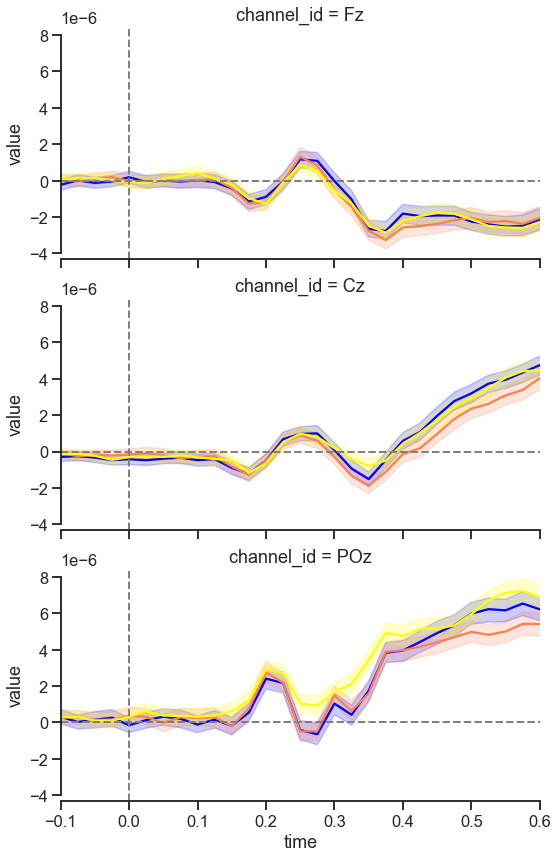

In [526]:
# Plot the responses for different events and regions
erp_plot = sns.relplot(x="time", y="value",ci=95,
             hue="condition",row="channel_id",kind="line",# style="event",
            palette = ['blue', 'coral','yellow'],legend=False,
             data=data2plot)

erp_plot.set(xlim=(-0.1, 0.6))
erp_plot.set(xticks=[-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
erp_plot.fig.set_figwidth(8.27)
erp_plot.fig.set_figheight(11.7)

for ax in erp_plot.axes.flat:
    ax.axvline(0, ls='--', linewidth=2, color="gray")
    ax.axhline(0, ls='--', linewidth=2, color="gray")

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

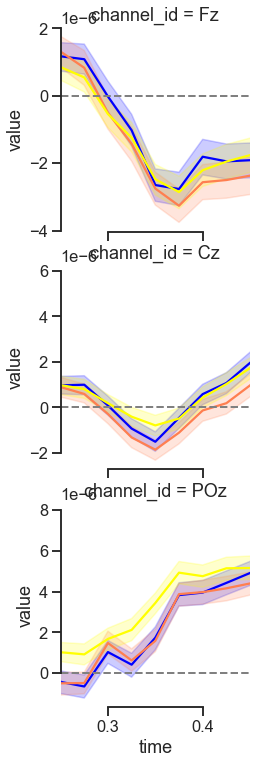

In [528]:
# Plot the responses for different events and regions
erp_plot = sns.relplot(x="time", y="value",ci=95,
             hue="condition",row="channel_id",kind="line",# style="event",
            palette = ['blue', 'coral','yellow'],legend=False,
             data=data2plot, facet_kws={'sharey': False, 'sharex': True})

erp_plot.set(xlim=(0.25, 0.45))
#erp_plot.set(xticks=[-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
erp_plot.fig.set_figwidth(3.27)
erp_plot.fig.set_figheight(10.27)

for ax in erp_plot.axes.flat:
    ax.axvline(0, ls='--', linewidth=2, color="gray")
    ax.axhline(0, ls='--', linewidth=2, color="gray")

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

## plot with OB1 lexicon activity _ no inhib

In [583]:
df = pd.read_pickle('E:/Projects/2020_reading/Flankerlexicon_noInhib.pkl')
bindict = dict(zip(df['stimulus'], df['bin']))
actdict = dict(zip(df['stimulus'], df['lexicon activity per cycle']))

lexicon2plot = data2plot.copy(deep=True)

lexicon2plot['bin'] = lexicon2plot['stimulus'].map(bindict)
lexicon2plot['OB1 activity'] = lexicon2plot['stimulus'].map(actdict)


lexiconN250 = lexicon2plot[(lexicon2plot['time']>.175) & (lexicon2plot['time']< .25)].copy(deep=True)
lexiconN400 = lexicon2plot[(lexicon2plot['time']>.25) & (lexicon2plot['time']< .45)].copy(deep=True)
lexiconP600 = lexicon2plot[(lexicon2plot['time']>.59) & (lexicon2plot['time']< .61)].copy(deep=True)

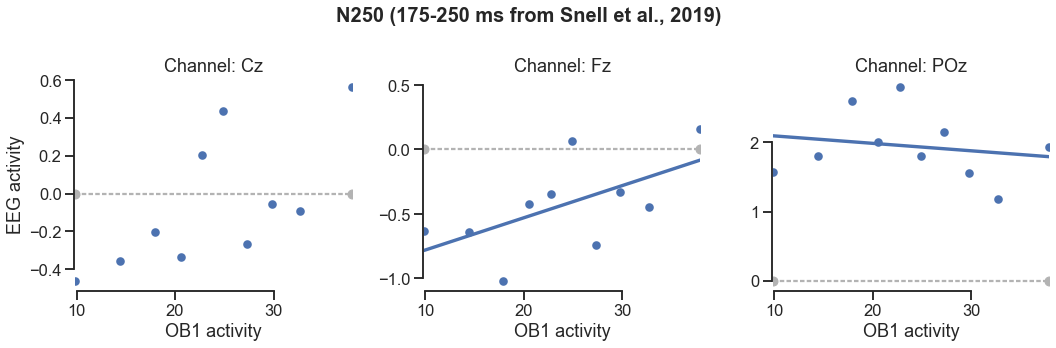

In [584]:
# Show the results of a linear regression within each dataset
sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")

g = sns.lmplot(x="OB1 activity", y="value", col="channel_id", data=lexiconN250.groupby(['bin', 'channel_id'],as_index=False).mean(),
           col_order=['Cz', 'Fz', 'POz'],#col_wrap=2, 
            palette="muted", height=5 ,x_estimator=np.mean,fit_reg=True,sharey=False, ci=None,
           scatter_kws={"s": 50, "alpha": 1})
# g.set(xticks=[0,2,4,6,8])
g.fig.suptitle("N250 (175-250 ms from Snell et al., 2019)", size=20, weight="bold")


(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("OB1 activity", "EEG activity")
  .set_titles("Channel: {col_name}")
  .tight_layout(w_pad=1))

sns.despine(offset=0.9, trim=True)

In [585]:
fz = lexiconN250[lexiconN250["channel_id"]=="Fz"].groupby(['bin'],as_index=False).mean().copy(deep=True)
# print(scipy.stats.normaltest(fz['OB1 activity']))
# print(scipy.stats.normaltest(fz['value']))
print(scipy.stats.spearmanr(fz['OB1 activity'], fz['value']))

SpearmanrResult(correlation=0.5636363636363636, pvalue=0.08972402831709127)


In [586]:
cz = lexiconN250[lexiconN250["channel_id"]=="Cz"].groupby(['bin']).mean().copy(deep=True)
scipy.stats.pearsonr(cz['OB1 activity'], cz['value'])

(0.677957080401203, 0.031200302968534356)

In [587]:
poz = lexiconN250[lexiconN250["channel_id"]=="POz"].groupby(['bin']).mean().copy(deep=True)
scipy.stats.pearsonr(poz['OB1 activity'], poz['value'])

(-0.1902172852851313, 0.5986312513181112)

### N400

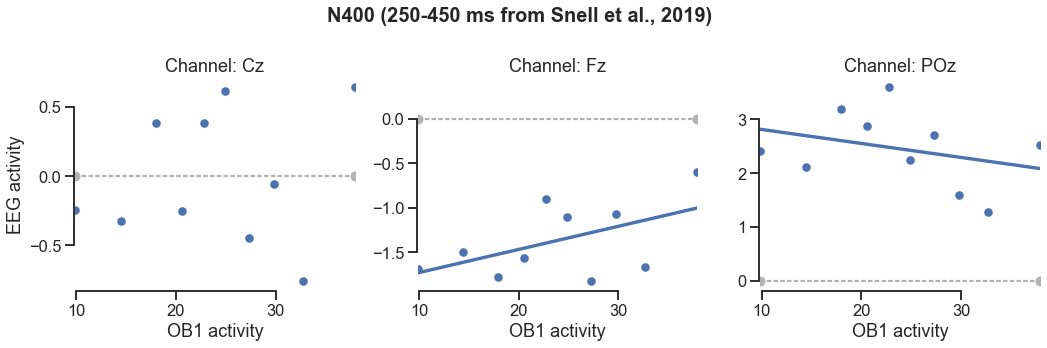

In [588]:
# Show the results of a linear regression within each dataset
sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")

g = sns.lmplot(x="OB1 activity", y="value", col="channel_id", data=lexiconN400.groupby(['bin', 'channel_id'],as_index=False).mean(),
           col_order=['Cz', 'Fz', 'POz'],#col_wrap=2, 
            palette="muted", height=5 ,x_estimator=np.mean,fit_reg=True,sharey=False, ci=None,
           scatter_kws={"s": 50, "alpha": 1})
# g.set(xticks=[0,2,4,6,8,10])
g.fig.suptitle("N400 (250-450 ms from Snell et al., 2019)", size=20, weight="bold")


(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("OB1 activity", "EEG activity")
  .set_titles("Channel: {col_name}")
  .tight_layout(w_pad=1))

sns.despine(offset=0.9, trim=True)

In [589]:
fz = lexiconN400[lexiconN400["channel_id"]=="Fz"].groupby(['bin'],as_index=False).mean().copy(deep=True)
scipy.stats.spearmanr(fz['OB1 activity'], fz['value'])

SpearmanrResult(correlation=0.3939393939393939, pvalue=0.25999776683488757)

In [590]:
cz = lexiconN400[lexiconN400["channel_id"]=="Cz"].groupby(['bin'],as_index=False).mean().copy(deep=True)
scipy.stats.spearmanr(cz['OB1 activity'], cz['value'])

SpearmanrResult(correlation=0.10303030303030303, pvalue=0.7769984634438898)

In [591]:
poz = lexiconN400[lexiconN400["channel_id"]=="POz"].groupby(['bin'],as_index=False).mean().copy(deep=True)
scipy.stats.spearmanr(poz['OB1 activity'], poz['value'])

SpearmanrResult(correlation=-0.29696969696969694, pvalue=0.4047016712701569)